# We will try tracking the hands with just 6 landmarks, which will be a 6 x 3 x 2 = 36 length vector for each time step. 

In [165]:
import cv2, os 
import numpy as np 
import warnings
warnings.filterwarnings('ignore')

In [166]:
import mediapipe as mp 
from PIL import Image as im 
import mediapipe as mp

def hand_locations(frame, min_detection_confidence = 0.5, min_tracking_confidence = 0.5): 
    """Only give 6 landmarks"""

    hands = mp.solutions.hands.Hands(min_detection_confidence=min_detection_confidence, min_tracking_confidence=min_tracking_confidence) # MAKE SURE THIS IS ALL GOOD 
    results = hands.process(frame.astype('uint8'))
    X_locations = [0] * 12
    Y_locations = [0] * 12
    Z_locations = [0] * 12

    if results.multi_hand_landmarks:
        x = y = z = 0 
        for hand, hand_landmark in enumerate(results.multi_hand_landmarks):
            for i in range(0, 21):
                if i not in [0, 4, 8, 12, 16, 20]: continue 
                landmark = hand_landmark.landmark[i]
                X_locations[x] = landmark.x
                Y_locations[y] = landmark.y 
                Z_locations[z] = landmark.z
                x += 1; y += 1; z +=1; 
            
    hands.close()
    return np.concatenate([X_locations, Y_locations, Z_locations]) 

In [167]:
#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
import matplotlib.pyplot as plt 
def plot(history, show_pr = False, num = None): 
    
    if num: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision_{num}'], label = "train_precision")
            plt.plot(history.history[f'val_precision_{num}'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall_{num}'], label = "train_recall")
            plt.plot(history.history[f'val_recall_{num}'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    else: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision'], label = "train_precision")
            plt.plot(history.history[f'val_precision'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall'], label = "train_recall")
            plt.plot(history.history[f'val_recall'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    # let's see whether it can detect me not doing anything 

# we can create a padding function in order to pad 
def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = locations.tolist() 
    empty_row = np.zeros((1, 36))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)
    
def predict_on_video(model, path): 
    LOCATIONS = []
    cap = cv2.VideoCapture(path)
    while cap.isOpened():
        _, frame = cap.read()
        if not _: break 

        LOCATIONS.append(hand_locations(frame))
    LOCATIONS = pad(np.array([LOCATIONS]),maxlen=90)
    return model.predict(LOCATIONS)


In [168]:
import random 
import tensorflow as tf 
tf.config.run_functions_eagerly(True)
from tensorflow.keras.callbacks import ReduceLROnPlateau

def _shift(X):
        
        X = tf.Variable(X, dtype = tf.float32)
        
        X_locations = X[:, :12] 
        Y_locations = X[:,  12:24] 
        Z_locations = X[:, 24:]
        
        mask = tf.not_equal(Y_locations, 0) 
        nonzero_Y_locations = tf.boolean_mask(Y_locations, mask) # contains all nonzero elements of Y_locations 
    
        maximum = tf.math.reduce_max(nonzero_Y_locations)
        minimum = tf.math.reduce_min(nonzero_Y_locations)

        can_move_up = 1 - maximum 
        can_move_down = minimum 
        mask = tf.cast(mask, tf.float32)
    
        if tf.random.uniform((1,)) > 0.5: 
            move_up = tf.random.uniform((1,), 0, can_move_up)
            X[:,  12:24].assign(X[:,  12:24] + mask * tf.ones_like(X[:,  12:24]) * move_up)
        else: 

            move_down = tf.random.uniform((1,), 0, can_move_down)
            X[:,  12:24].assign(X[:,  12:24] - mask * tf.ones_like(X[:,  12:24]) * move_down)

        mask = tf.not_equal(X_locations, 0) 
        nonzero_X_locations = tf.boolean_mask(X_locations, mask) 

        maximum = tf.math.reduce_max(nonzero_X_locations)
        minimum = tf.math.reduce_min(nonzero_X_locations)
            
        can_move_right = 1- maximum
        can_move_left = minimum 
        mask = tf.cast(mask, tf.float32)

        if tf.random.uniform((1,)) > 0.5: 
            # move right
            move_right = tf.random.uniform((1,), 0, can_move_right)
            X[:, :12].assign(X[:, :12] + mask * tf.ones_like(X[:, :12]) * move_right)

        else: 
            # move left 
            move_left = tf.random.uniform((1,), 0, can_move_left)
            X[:, :12].assign(X[:, :12] - mask * tf.ones_like(X[:, :12]) * move_left)

        mask = tf.not_equal(Z_locations, 0) 
        nonzero_Z_locations = tf.boolean_mask(Z_locations, mask)

        maximum = tf.math.reduce_max(nonzero_Z_locations)
        minimum = tf.math.reduce_min(nonzero_Z_locations)
        mask = tf.cast(mask, tf.float32)

        can_move_far = 1 - maximum 
        can_move_close = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            # move far
            move_far = tf.random.uniform((1,), 0, can_move_far)
            X[:, 24:].assign(X[:, 24:] + mask * tf.ones_like(X[:, 24:]) * move_far)
        else: 
            # move close 
            move_close = tf.random.uniform((1,), 0, can_move_close)
            X[:, 24:].assign(X[:, 24:] - mask * tf.ones_like(X[:, 24:]) * move_close)

        return X

class Augmenter(tf.keras.layers.Layer): 
    def __init__(self, rotation_range = None): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        self.rotation_range = rotation_range 
    
    def _rotate(self, X):  
        """
        new_x = X * np.cos(theta * np.pi/180) + y * np.sin(theta * np.pi/180)
        new_y = -X * np.sin(theta* np.pi/180) + y * np.cos(theta * np.pi/180)
        """
        X = tf.Variable(X, dtype = tf.float32)

        pi = 3.1415
        rotate_by = tf.random.uniform((1,), -self.rotation_range, self.rotation_range)
        X[:, :12].assign(X[:, :12] * tf.math.cos(rotate_by * pi/180) + X[:, 12:24] * tf.math.sin(rotate_by * pi/180))
        X[:, 12:24].assign(X[:, 12:24] * tf.math.cos(rotate_by * pi/180) - X[:, :12] * tf.math.sin(rotate_by * pi/180))
        return X 

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'vocab_size': 0,
            'num_layers': 1,
            'units': 0,
            'd_model': 1,
            'num_heads': 1,
            'dropout': 0,
        })
        return config
        
    def call(self, X, training = True):
        if training: 
            X =  tf.map_fn(_shift, X)
            if self.rotation_range: 
                X = tf.map_fn(self._rotate, X)
            return X
        else: 
            return X 

class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_accuracy') > 0.9):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(0.9*100))   
            self.model.stop_training = True  
        

In [169]:
import pickle
import os
import numpy as np 

X = []
y = []

for file in os.listdir('six_point_folds'): 
    with open(f"six_point_folds/{file}", 'rb') as f: 
        X_i, y_i = pickle.load(f)
        X.append(X_i)
        y.append(y_i)

X = np.array(X)
y = np.array(y)

In [170]:
def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = locations.tolist() 
    empty_row = np.zeros((1, 36))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)

In [171]:
from scipy import interpolate
def adjust(frame_matrix): 
    assert len(frame_matrix.shape) == 2
    rows, columns = frame_matrix.shape
    for column in range(columns): 
        loc_dimension = frame_matrix[column]
        x = np.arange(0, rows, 1)
        idx = np.nonzero(loc_dimension)
        if len(idx) == 1: 
            continue 
        interp_func = interpolate.interp1d(x[idx], loc_dimension[idx], kind='cubic', fill_value = "extrapolate")
        frame_matrix[:, column] = interp_func(x) 
    return frame_matrix

def interp_X(X): 
    temp_X = np.concatenate([X_i for X_i in X])
    temp_X =  np.array([adjust(temp_X_i) for temp_X_i in temp_X])
    print(temp_X.shape)
    return temp_X.reshape(X.shape)

In [172]:
def plot_roc_auroc(base_fpr, TPRs, FPRs, aurocs): 
    

    for i, (tpr, fpr) in enumerate(zip(TPRs, FPRs)): 
        plt.plot(base_fpr, tpr, label = f"fold {i + 1}")

    mean_tpr = np.mean(TPRs, axis=0)
    plt.plot(base_fpr, mean_tpr, label = "average of folds")
    
    std_tpr = np.std(TPRs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3,
                 label=r'$\pm$ 1 std. dev.')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve across folds')
    plt.legend(loc="lower right")
    plt.show()

    # plot the auroc curves 
    mean_auroc = sum(aurocs) / len(aurocs)
    descriptions = [f"fold {i + 1}" for i in range(len(aurocs))] + ["average fold"]
    aurocs.append(mean_auroc)
    plt.bar(descriptions, aurocs, color = "green")
    plt.xlabel("Fold")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across folds")
    plt.show() 

    return mean_tpr, mean_auroc

def plot_meta_roc_auroc(average_aurocs, average_tprs, base_fpr): 
    meta_avg_tpr = np.mean(average_tprs, axis = 0) 
    meta_avg_auroc = sum(average_aurocs) / len(average_aurocs)
    
    for i, average_tpr in enumerate(average_tprs): 
        plt.plot(base_fpr, average_tpr, label = f"run {i + 1}")
    
    plt.plot(base_fpr, meta_avg_tpr, label = "average of runs")
    
    std_tpr = np.std(average_tprs, axis=0)
    tprs_upper = np.minimum(meta_avg_tpr + std_tpr, 1)
    tprs_lower = np.maximum(meta_avg_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3, label=r'$\pm$ 1 std. dev.')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve across Runs (With Aug)')
    plt.legend(loc="lower right")
    plt.show()

    descriptions = [f"{i + 1}" for i in range(len(average_aurocs))] + ["avg"]
    average_aurocs.append(meta_avg_auroc)
    plt.bar(descriptions, average_aurocs, color = "green")
    plt.xlabel("Run Number")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across Runs (With Aug)")
    plt.show()

In [173]:
from glob import glob
from tqdm import tqdm 
from scipy import interp
import tensorflow_addons as tfa
from sklearn.metrics import roc_curve, roc_auc_score
AVERAGE_TPRS, AVERAGE_AUROCS = [], [] 
def cross_validate(make_model, epochs = 50, callbacks=[]):
    model = make_model()

    base_fpr = np.linspace(0, 1, 101)
    FPRS, TPRS, AUROCS = [], [], []
    for i in range(X.shape[0]): 
        model = make_model()

        X_test, y_test = X[i], y[i]
        X_train = np.concatenate([X_j for j, X_j in enumerate(X) if i != j])
        y_train = np.concatenate([y_j for j, y_j in enumerate(y) if i != j])

        try:
            os.remove("best.h5") 
        except Exception as e: 
            pass 

        # train 
        history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, callbacks = callbacks)
        
        try: 
            model.load_weights("best.h5")
        except Exception as e: 
            pass 

        # evaluate again 
        model.evaluate(X_test, y_test)
        
        # plot accuracy and loss 
        plot(history)

        # get this information  
        y_pred = model.predict(X_test).flatten()
        fpr, tpr, _ = roc_curve(y_test, y_pred) 
        FPRS.append(fpr)
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0 
        TPRS.append(tpr)
        AUROCS.append(roc_auc_score(y_test, y_pred))

        # evaluate on our own custom videos
        for file in glob("*.mov"):
            print(f"prediction for video {file} is {predict_on_video(model, file)}")

    mean_tpr, mean_auroc = plot_roc_auroc(base_fpr, TPRS, FPRS, AUROCS) 
    AVERAGE_TPRS.append(mean_tpr) 
    AVERAGE_AUROCS.append(mean_auroc)

In [174]:
# don't shuffle  

"""import random 
def shuffle(X, y, seed = None):
    if seed == None:  
        seed = random.randrange(0, 100)
        print(f"using seed {seed}")
    np.random.seed(seed) 
    new_X = np.concatenate([X_i for X_i in X])
    new_y = np.concatenate([y_i for y_i in y])
    N = np.random.permutation(new_X.shape[0])
    new_X = new_X[N]
    new_y = new_y[N]
    new_X = new_X.reshape(5, 20, 90, 36)
    new_y = new_y.reshape(5, 20)
    return new_X, new_y

X, y = shuffle(X, y, seed = 90)"""

'import random \ndef shuffle(X, y, seed = None):\n    if seed == None:  \n        seed = random.randrange(0, 100)\n        print(f"using seed {seed}")\n    np.random.seed(seed) \n    new_X = np.concatenate([X_i for X_i in X])\n    new_y = np.concatenate([y_i for y_i in y])\n    N = np.random.permutation(new_X.shape[0])\n    new_X = new_X[N]\n    new_y = new_y[N]\n    new_X = new_X.reshape(5, 20, 90, 36)\n    new_y = new_y.reshape(5, 20)\n    return new_X, new_y\n\nX, y = shuffle(X, y, seed = 90)'

In [175]:
def f1(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.math.reduce_sum(tf.cast(y_true*y_pred, 'float'), axis=0)
    tn = tf.math.reduce_sum(tf.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = tf.math.reduce_sum(tf.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = tf.math.reduce_sum(tf.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + tf.keras.backend.epsilon())
    r = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2*p*r / (p+r+tf.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return tf.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = tf.math.reduce_sum(tf.cast(y_true*y_pred, 'float'), axis=0)
    tn = tf.math.reduce_sum(tf.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = tf.math.reduce_sum(tf.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = tf.math.reduce_sum(tf.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + tf.keras.backend.epsilon())
    r = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2*p*r / (p+r+tf.keras.backend.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - tf.math.reduce_mean(f1)

In [176]:
def make_model(): 
    model = tf.keras.models.Sequential([
        Augmenter(), 
        tf.keras.layers.LSTM(64, return_sequences=False, input_shape = (None, 36)), 
        tf.keras.layers.Dropout(0.3), 
        tf.keras.layers.Dense(1, activation = 'sigmoid') 
    ]) 

    model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model

In [177]:
original_X = X
original_Y = y 

In [178]:
"""def shuffle(X, y, seed = None):
    if seed == None:  
        seed = random.randrange(0, 100)
        print(f"using seed {seed}")
    np.random.seed(seed) 
    new_X = np.concatenate([X_i for X_i in X])
    new_y = np.concatenate([y_i for y_i in y])
    N = np.random.permutation(new_X.shape[0])
    new_X = new_X[N]
    new_y = new_y[N]
    new_X = new_X.reshape(5, 20, 90, 36)
    new_y = new_y.reshape(5, 20)
    return new_X, new_y

X, y = shuffle(original_X, original_Y, seed=65)"""

'def shuffle(X, y, seed = None):\n    if seed == None:  \n        seed = random.randrange(0, 100)\n        print(f"using seed {seed}")\n    np.random.seed(seed) \n    new_X = np.concatenate([X_i for X_i in X])\n    new_y = np.concatenate([y_i for y_i in y])\n    N = np.random.permutation(new_X.shape[0])\n    new_X = new_X[N]\n    new_y = new_y[N]\n    new_X = new_X.reshape(5, 20, 90, 36)\n    new_y = new_y.reshape(5, 20)\n    return new_X, new_y\n\nX, y = shuffle(original_X, original_Y, seed=65)'

Epoch 1/75
3/3 [==============================] - 2s 463ms/step - loss: 0.7606 - accuracy: 0.4875 - precision_61: 0.4921 - recall_61: 0.7750 - val_loss: 0.6900 - val_accuracy: 0.6500 - val_precision_61: 0.6364 - val_recall_61: 0.7000
Epoch 2/75
3/3 [==============================] - 1s 327ms/step - loss: 0.6779 - accuracy: 0.6250 - precision_61: 0.7500 - recall_61: 0.3750 - val_loss: 0.6863 - val_accuracy: 0.5500 - val_precision_61: 0.5714 - val_recall_61: 0.4000
Epoch 3/75
3/3 [==============================] - 1s 396ms/step - loss: 0.6310 - accuracy: 0.6875 - precision_61: 0.7273 - recall_61: 0.6000 - val_loss: 0.7024 - val_accuracy: 0.7500 - val_precision_61: 0.6923 - val_recall_61: 0.9000
Epoch 4/75
3/3 [==============================] - 1s 445ms/step - loss: 0.6325 - accuracy: 0.6750 - precision_61: 0.6458 - recall_61: 0.7750 - val_loss: 0.6892 - val_accuracy: 0.7000 - val_precision_61: 0.6429 - val_recall_61: 0.9000
Epoch 5/75
3/3 [==============================] - 1s 322ms/step 

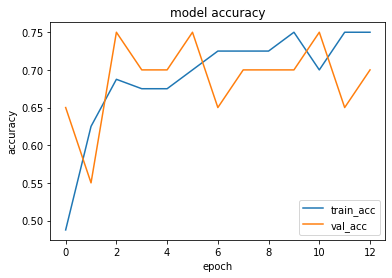

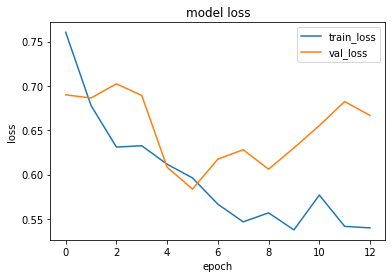

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.48851335]]


1it [00:00, 14315.03it/s]


prediction for video armflapping_3.mov is [[0.54225105]]


1it [00:00, 14027.77it/s]


prediction for video armflapping_2.mov is [[0.5267088]]


1it [00:00, 14716.86it/s]


prediction for video control_1.mov is [[0.47241908]]


1it [00:00, 15650.39it/s]


prediction for video control_2.mov is [[0.4671941]]


1it [00:00, 15420.24it/s]


prediction for video control_3.mov is [[0.46497598]]
Epoch 1/75
3/3 [==============================] - 1s 355ms/step - loss: 0.7180 - accuracy: 0.5625 - precision_62: 0.5352 - recall_62: 0.9500 - val_loss: 0.7325 - val_accuracy: 0.5000 - val_precision_62: 0.0000e+00 - val_recall_62: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 1s 344ms/step - loss: 0.7601 - accuracy: 0.5000 - precision_62: 0.0000e+00 - recall_62: 0.0000e+00 - val_loss: 0.6469 - val_accuracy: 0.7000 - val_precision_62: 0.7500 - val_recall_62: 0.6000
Epoch 3/75
3/3 [==============================] - 1s 315ms/step - loss: 0.6491 - accuracy: 0.6750 - precision_62: 0.7059 - recall_62: 0.6000 - val_loss: 0.6021 - val_accuracy: 0.7000 - val_precision_62: 0.6429 - val_recall_62: 0.9000
Epoch 4/75
3/3 [==============================] - 1s 301ms/step - loss: 0.6460 - accuracy: 0.6750 - precision_62: 0.6296 - recall_62: 0.8500 - val_loss: 0.5864 - val_accuracy: 0.6500 - val_precision_62: 0.6000 - val_recall_62: 0.

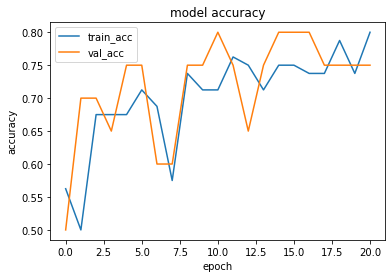

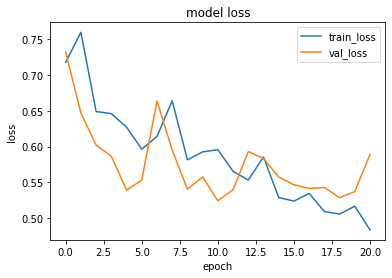

1it [00:00, 15592.21it/s]


prediction for video armflapping_1.mov is [[0.4971194]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_3.mov is [[0.3960624]]


1it [00:00, 15420.24it/s]


prediction for video armflapping_2.mov is [[0.5523065]]


1it [00:00, 14716.86it/s]


prediction for video control_1.mov is [[0.41096312]]


1it [00:00, 15650.39it/s]


prediction for video control_2.mov is [[0.3419159]]


1it [00:00, 15363.75it/s]


prediction for video control_3.mov is [[0.3452731]]
Epoch 1/75
3/3 [==============================] - 1s 395ms/step - loss: 0.7605 - accuracy: 0.4500 - precision_63: 0.4677 - recall_63: 0.7250 - val_loss: 0.6856 - val_accuracy: 0.7500 - val_precision_63: 0.8571 - val_recall_63: 0.6000
Epoch 2/75
3/3 [==============================] - 1s 333ms/step - loss: 0.6700 - accuracy: 0.6125 - precision_63: 0.7143 - recall_63: 0.3750 - val_loss: 0.6820 - val_accuracy: 0.6500 - val_precision_63: 0.6667 - val_recall_63: 0.6000
Epoch 3/75
3/3 [==============================] - 1s 311ms/step - loss: 0.6337 - accuracy: 0.7250 - precision_63: 0.7368 - recall_63: 0.7000 - val_loss: 0.6731 - val_accuracy: 0.6500 - val_precision_63: 0.6364 - val_recall_63: 0.7000
Epoch 4/75
3/3 [==============================] - 1s 318ms/step - loss: 0.6174 - accuracy: 0.7250 - precision_63: 0.6957 - recall_63: 0.8000 - val_loss: 0.6590 - val_accuracy: 0.7500 - val_precision_63: 0.7778 - val_recall_63: 0.7000
Epoch 5/75
3

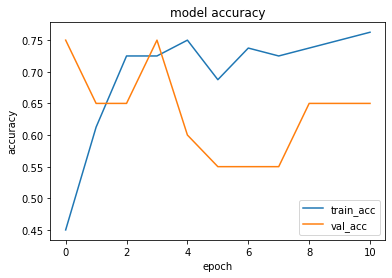

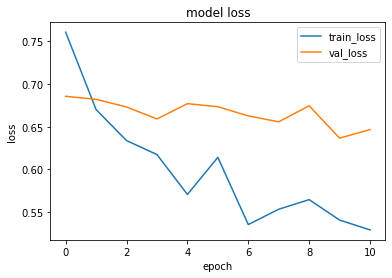

1it [00:00, 15650.39it/s]


prediction for video armflapping_1.mov is [[0.32787228]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.45892882]]


1it [00:00, 14463.12it/s]


prediction for video armflapping_2.mov is [[0.6168215]]


1it [00:00, 13530.01it/s]


prediction for video control_1.mov is [[0.2615329]]


1it [00:00, 5817.34it/s]


prediction for video control_2.mov is [[0.23388636]]


1it [00:00, 14979.66it/s]


prediction for video control_3.mov is [[0.23412886]]
Epoch 1/75
3/3 [==============================] - 1s 300ms/step - loss: 0.7136 - accuracy: 0.4250 - precision_64: 0.4483 - recall_64: 0.6500 - val_loss: 0.6401 - val_accuracy: 0.7500 - val_precision_64: 0.7273 - val_recall_64: 0.8000
Epoch 2/75
3/3 [==============================] - 1s 302ms/step - loss: 0.6479 - accuracy: 0.6875 - precision_64: 0.7778 - recall_64: 0.5250 - val_loss: 0.6167 - val_accuracy: 0.6500 - val_precision_64: 0.8000 - val_recall_64: 0.4000
Epoch 3/75
3/3 [==============================] - 1s 299ms/step - loss: 0.6566 - accuracy: 0.6250 - precision_64: 0.7500 - recall_64: 0.3750 - val_loss: 0.6081 - val_accuracy: 0.7000 - val_precision_64: 0.6667 - val_recall_64: 0.8000
Epoch 4/75
3/3 [==============================] - 1s 305ms/step - loss: 0.6108 - accuracy: 0.6750 - precision_64: 0.6400 - recall_64: 0.8000 - val_loss: 0.5588 - val_accuracy: 0.7500 - val_precision_64: 0.7273 - val_recall_64: 0.8000
Epoch 5/75


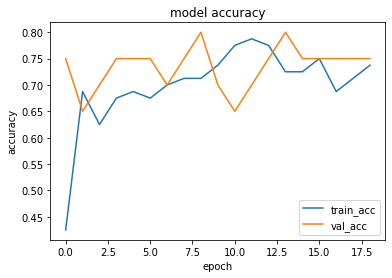

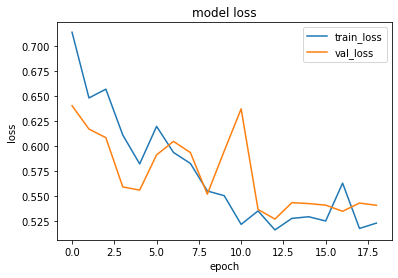

1it [00:00, 9597.95it/s]


prediction for video armflapping_1.mov is [[0.49511945]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.4488325]]


1it [00:00, 15827.56it/s]


prediction for video armflapping_2.mov is [[0.54071957]]


1it [00:00, 15363.75it/s]


prediction for video control_1.mov is [[0.40253595]]


1it [00:00, 16384.00it/s]


prediction for video control_2.mov is [[0.2910651]]


1it [00:00, 16448.25it/s]


prediction for video control_3.mov is [[0.3255166]]
Epoch 1/75
3/3 [==============================] - 1s 356ms/step - loss: 0.7121 - accuracy: 0.5125 - precision_65: 0.5079 - recall_65: 0.8000 - val_loss: 0.6435 - val_accuracy: 0.7500 - val_precision_65: 0.7778 - val_recall_65: 0.7000
Epoch 2/75
3/3 [==============================] - 1s 298ms/step - loss: 0.6606 - accuracy: 0.6500 - precision_65: 0.7000 - recall_65: 0.5250 - val_loss: 0.6207 - val_accuracy: 0.6500 - val_precision_65: 0.6667 - val_recall_65: 0.6000
Epoch 3/75
3/3 [==============================] - 1s 299ms/step - loss: 0.6373 - accuracy: 0.7125 - precision_65: 0.6735 - recall_65: 0.8250 - val_loss: 0.5588 - val_accuracy: 0.7500 - val_precision_65: 0.7273 - val_recall_65: 0.8000
Epoch 4/75
3/3 [==============================] - 1s 297ms/step - loss: 0.5901 - accuracy: 0.6875 - precision_65: 0.6744 - recall_65: 0.7250 - val_loss: 0.5512 - val_accuracy: 0.7500 - val_precision_65: 0.7778 - val_recall_65: 0.7000
Epoch 5/75
3

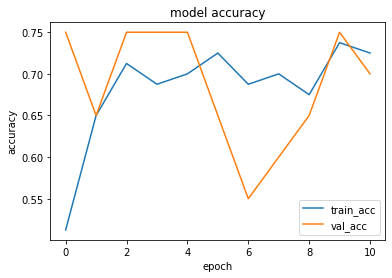

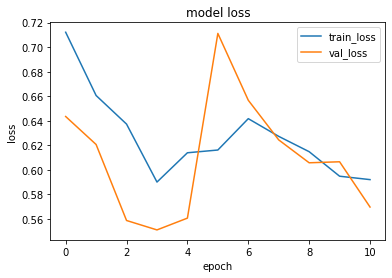

1it [00:00, 18236.10it/s]


prediction for video armflapping_1.mov is [[0.21939373]]


1it [00:00, 13148.29it/s]


prediction for video armflapping_3.mov is [[0.5936473]]


1it [00:00, 15196.75it/s]


prediction for video armflapping_2.mov is [[0.24686009]]


1it [00:00, 12372.58it/s]


prediction for video control_1.mov is [[0.21088898]]


1it [00:00, 14716.86it/s]


prediction for video control_2.mov is [[0.20909846]]


1it [00:00, 19972.88it/s]


prediction for video control_3.mov is [[0.20878217]]


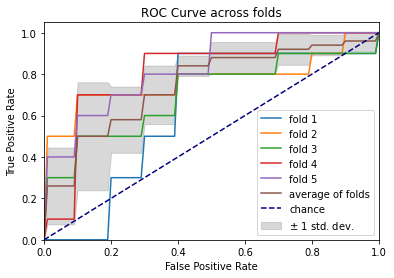

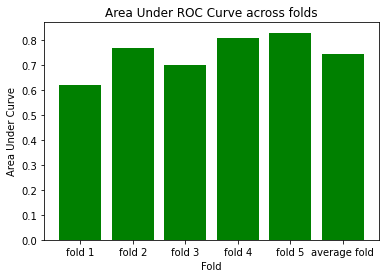

In [179]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 1s 347ms/step - loss: 0.6713 - accuracy: 0.6125 - precision_67: 0.6154 - recall_67: 0.6000 - val_loss: 0.6433 - val_accuracy: 0.6000 - val_precision_67: 0.5625 - val_recall_67: 0.9000
Epoch 2/75
3/3 [==============================] - 1s 308ms/step - loss: 0.6179 - accuracy: 0.7000 - precision_67: 0.7222 - recall_67: 0.6500 - val_loss: 0.6692 - val_accuracy: 0.7000 - val_precision_67: 0.6429 - val_recall_67: 0.9000
Epoch 3/75
3/3 [==============================] - 1s 321ms/step - loss: 0.5773 - accuracy: 0.7250 - precision_67: 0.7500 - recall_67: 0.6750 - val_loss: 0.6971 - val_accuracy: 0.6500 - val_precision_67: 0.6154 - val_recall_67: 0.8000
Epoch 4/75
3/3 [==============================] - 1s 362ms/step - loss: 0.6107 - accuracy: 0.7250 - precision_67: 0.7647 - recall_67: 0.6500 - val_loss: 0.6317 - val_accuracy: 0.7000 - val_precision_67: 0.6429 - val_recall_67: 0.9000
Epoch 5/75
3/3 [==============================] - 1s 291ms/step 

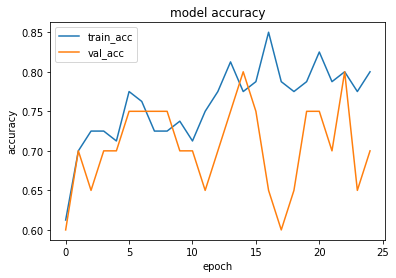

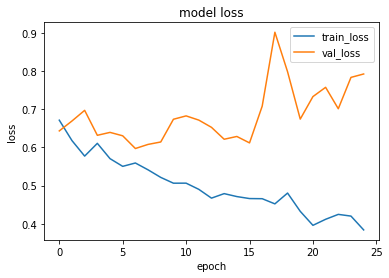

1it [00:00, 14513.16it/s]


prediction for video armflapping_1.mov is [[0.59180343]]


1it [00:00, 16194.22it/s]


prediction for video armflapping_3.mov is [[0.6335297]]


1it [00:00, 14979.66it/s]


prediction for video armflapping_2.mov is [[0.67920464]]


1it [00:00, 14266.34it/s]


prediction for video control_1.mov is [[0.4850059]]


1it [00:00, 16131.94it/s]


prediction for video control_2.mov is [[0.32059187]]


1it [00:00, 15650.39it/s]


prediction for video control_3.mov is [[0.35796964]]
Epoch 1/75
3/3 [==============================] - 1s 300ms/step - loss: 0.6956 - accuracy: 0.4500 - precision_68: 0.4643 - recall_68: 0.6500 - val_loss: 0.7260 - val_accuracy: 0.6000 - val_precision_68: 1.0000 - val_recall_68: 0.2000
Epoch 2/75
3/3 [==============================] - 1s 333ms/step - loss: 0.6855 - accuracy: 0.6750 - precision_68: 0.7059 - recall_68: 0.6000 - val_loss: 0.6455 - val_accuracy: 0.6000 - val_precision_68: 0.6000 - val_recall_68: 0.6000
Epoch 3/75
3/3 [==============================] - 1s 331ms/step - loss: 0.6210 - accuracy: 0.6625 - precision_68: 0.6182 - recall_68: 0.8500 - val_loss: 0.6403 - val_accuracy: 0.6000 - val_precision_68: 0.5833 - val_recall_68: 0.7000
Epoch 4/75
3/3 [==============================] - 1s 325ms/step - loss: 0.5844 - accuracy: 0.7375 - precision_68: 0.7209 - recall_68: 0.7750 - val_loss: 0.6008 - val_accuracy: 0.7500 - val_precision_68: 0.7778 - val_recall_68: 0.7000
Epoch 5/75


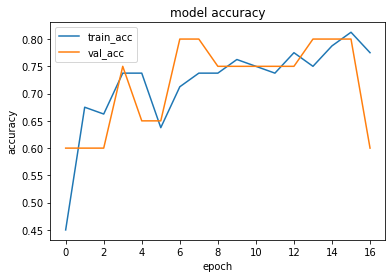

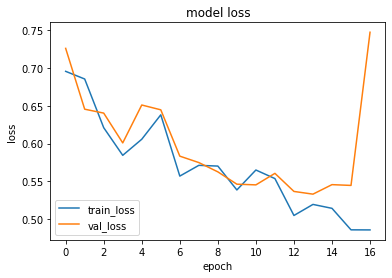

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.5453926]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_3.mov is [[0.46669593]]


1it [00:00, 13148.29it/s]


prediction for video armflapping_2.mov is [[0.6809971]]


1it [00:00, 15141.89it/s]


prediction for video control_1.mov is [[0.32708684]]


1it [00:00, 16710.37it/s]


prediction for video control_2.mov is [[0.25002623]]


1it [00:00, 15141.89it/s]


prediction for video control_3.mov is [[0.23955277]]
Epoch 1/75
3/3 [==============================] - 1s 304ms/step - loss: 0.7091 - accuracy: 0.5625 - precision_69: 0.5373 - recall_69: 0.9000 - val_loss: 0.6920 - val_accuracy: 0.5500 - val_precision_69: 1.0000 - val_recall_69: 0.1000
Epoch 2/75
3/3 [==============================] - 1s 297ms/step - loss: 0.6784 - accuracy: 0.5250 - precision_69: 0.7500 - recall_69: 0.0750 - val_loss: 0.6888 - val_accuracy: 0.5500 - val_precision_69: 0.5714 - val_recall_69: 0.4000
Epoch 3/75
3/3 [==============================] - 1s 296ms/step - loss: 0.6396 - accuracy: 0.6625 - precision_69: 0.6970 - recall_69: 0.5750 - val_loss: 0.6705 - val_accuracy: 0.6500 - val_precision_69: 0.6364 - val_recall_69: 0.7000
Epoch 4/75
3/3 [==============================] - 1s 346ms/step - loss: 0.6143 - accuracy: 0.7000 - precision_69: 0.6600 - recall_69: 0.8250 - val_loss: 0.6527 - val_accuracy: 0.6000 - val_precision_69: 0.6000 - val_recall_69: 0.6000
Epoch 5/75


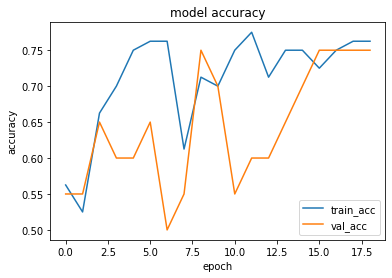

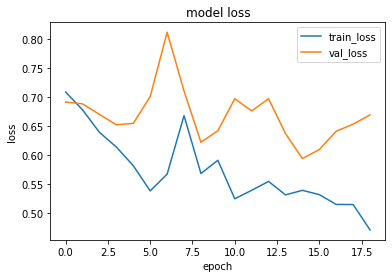

1it [00:00, 13706.88it/s]


prediction for video armflapping_1.mov is [[0.50388336]]


1it [00:00, 17924.38it/s]


prediction for video armflapping_3.mov is [[0.55013597]]


1it [00:00, 14266.34it/s]


prediction for video armflapping_2.mov is [[0.707273]]


1it [00:00, 14122.24it/s]


prediction for video control_1.mov is [[0.47249463]]


1it [00:00, 14716.86it/s]


prediction for video control_2.mov is [[0.17415819]]


1it [00:00, 14926.35it/s]


prediction for video control_3.mov is [[0.4447946]]
Epoch 1/75
3/3 [==============================] - 1s 302ms/step - loss: 0.6979 - accuracy: 0.4125 - precision_70: 0.4340 - recall_70: 0.5750 - val_loss: 0.6348 - val_accuracy: 0.7500 - val_precision_70: 0.7273 - val_recall_70: 0.8000
Epoch 2/75
3/3 [==============================] - 1s 354ms/step - loss: 0.6716 - accuracy: 0.7000 - precision_70: 0.7222 - recall_70: 0.6500 - val_loss: 0.6326 - val_accuracy: 0.6000 - val_precision_70: 0.6667 - val_recall_70: 0.4000
Epoch 3/75
3/3 [==============================] - 1s 315ms/step - loss: 0.6352 - accuracy: 0.6500 - precision_70: 0.8333 - recall_70: 0.3750 - val_loss: 0.6168 - val_accuracy: 0.7000 - val_precision_70: 0.6667 - val_recall_70: 0.8000
Epoch 4/75
3/3 [==============================] - 1s 291ms/step - loss: 0.6093 - accuracy: 0.6875 - precision_70: 0.6667 - recall_70: 0.7500 - val_loss: 0.5379 - val_accuracy: 0.7500 - val_precision_70: 0.7273 - val_recall_70: 0.8000
Epoch 5/75
3

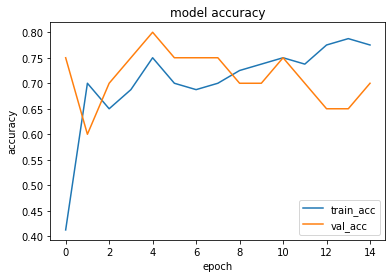

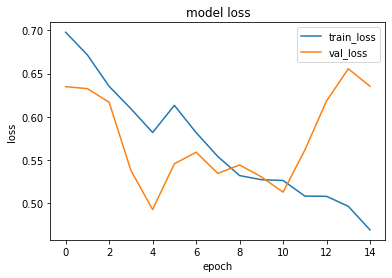

1it [00:00, 13706.88it/s]


prediction for video armflapping_1.mov is [[0.44539618]]


1it [00:00, 14074.85it/s]


prediction for video armflapping_3.mov is [[0.7614131]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_2.mov is [[0.7703576]]


1it [00:00, 15363.75it/s]


prediction for video control_1.mov is [[0.19893616]]


1it [00:00, 15887.52it/s]


prediction for video control_2.mov is [[0.17227465]]


1it [00:00, 14463.12it/s]


prediction for video control_3.mov is [[0.17019641]]
Epoch 1/75
3/3 [==============================] - 1s 305ms/step - loss: 0.7130 - accuracy: 0.4375 - precision_71: 0.4603 - recall_71: 0.7250 - val_loss: 0.6614 - val_accuracy: 0.5500 - val_precision_71: 0.5455 - val_recall_71: 0.6000
Epoch 2/75
3/3 [==============================] - 1s 296ms/step - loss: 0.6601 - accuracy: 0.6750 - precision_71: 0.6842 - recall_71: 0.6500 - val_loss: 0.6241 - val_accuracy: 0.7000 - val_precision_71: 0.7000 - val_recall_71: 0.7000
Epoch 3/75
3/3 [==============================] - 1s 289ms/step - loss: 0.6522 - accuracy: 0.5875 - precision_71: 0.5574 - recall_71: 0.8500 - val_loss: 0.5812 - val_accuracy: 0.7500 - val_precision_71: 0.7273 - val_recall_71: 0.8000
Epoch 4/75
3/3 [==============================] - 1s 355ms/step - loss: 0.5907 - accuracy: 0.7125 - precision_71: 0.6735 - recall_71: 0.8250 - val_loss: 0.5436 - val_accuracy: 0.7500 - val_precision_71: 0.7273 - val_recall_71: 0.8000
Epoch 5/75


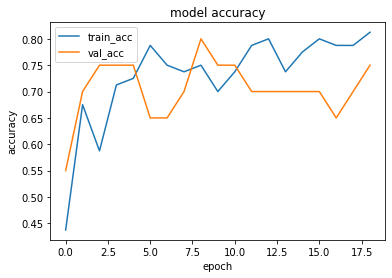

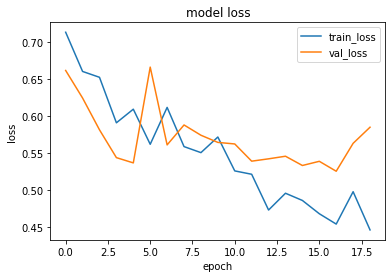

1it [00:00, 14716.86it/s]


prediction for video armflapping_1.mov is [[0.25881058]]


1it [00:00, 16320.25it/s]


prediction for video armflapping_3.mov is [[0.8082589]]


1it [00:00, 14027.77it/s]


prediction for video armflapping_2.mov is [[0.8447795]]


1it [00:00, 14926.35it/s]


prediction for video control_1.mov is [[0.17676836]]


1it [00:00, 16131.94it/s]


prediction for video control_2.mov is [[0.14872989]]


1it [00:00, 14768.68it/s]


prediction for video control_3.mov is [[0.1362324]]


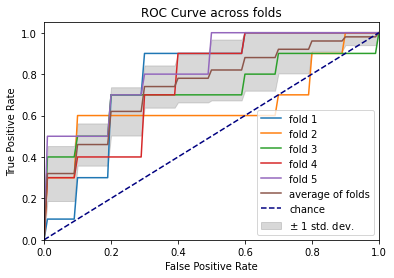

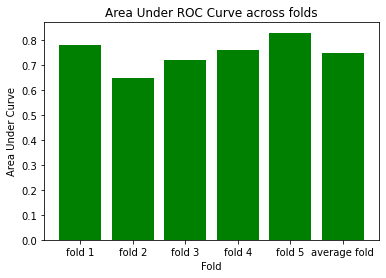

In [180]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 1s 321ms/step - loss: 0.7048 - accuracy: 0.5375 - precision_73: 0.5600 - recall_73: 0.3500 - val_loss: 0.7031 - val_accuracy: 0.6000 - val_precision_73: 0.5625 - val_recall_73: 0.9000
Epoch 2/75
3/3 [==============================] - 1s 311ms/step - loss: 0.6525 - accuracy: 0.7000 - precision_73: 0.6600 - recall_73: 0.8250 - val_loss: 0.6756 - val_accuracy: 0.6500 - val_precision_73: 0.6364 - val_recall_73: 0.7000
Epoch 3/75
3/3 [==============================] - 1s 333ms/step - loss: 0.6136 - accuracy: 0.7375 - precision_73: 0.7879 - recall_73: 0.6500 - val_loss: 0.6566 - val_accuracy: 0.5500 - val_precision_73: 0.5714 - val_recall_73: 0.4000
Epoch 4/75
3/3 [==============================] - 1s 319ms/step - loss: 0.5998 - accuracy: 0.7250 - precision_73: 0.7812 - recall_73: 0.6250 - val_loss: 0.6339 - val_accuracy: 0.6500 - val_precision_73: 0.6364 - val_recall_73: 0.7000
Epoch 5/75
3/3 [==============================] - 1s 294ms/step 

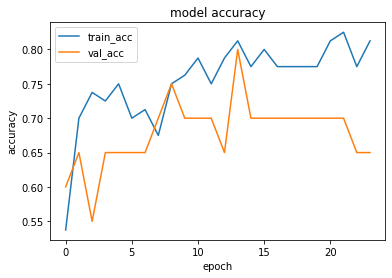

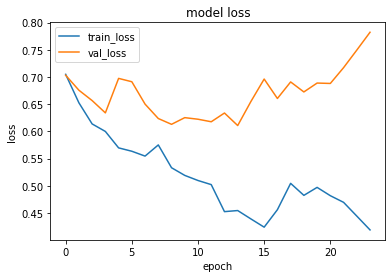

1it [00:00, 10407.70it/s]


prediction for video armflapping_1.mov is [[0.5802115]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_3.mov is [[0.7877522]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_2.mov is [[0.7043666]]


1it [00:00, 14027.77it/s]


prediction for video control_1.mov is [[0.42728505]]


1it [00:00, 14926.35it/s]


prediction for video control_2.mov is [[0.30679852]]


1it [00:00, 15592.21it/s]


prediction for video control_3.mov is [[0.3058101]]
Epoch 1/75
3/3 [==============================] - 1s 330ms/step - loss: 0.6814 - accuracy: 0.5625 - precision_74: 0.5352 - recall_74: 0.9500 - val_loss: 0.7564 - val_accuracy: 0.5000 - val_precision_74: 0.0000e+00 - val_recall_74: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 1s 347ms/step - loss: 0.7108 - accuracy: 0.5250 - precision_74: 0.7500 - recall_74: 0.0750 - val_loss: 0.6539 - val_accuracy: 0.7500 - val_precision_74: 1.0000 - val_recall_74: 0.5000
Epoch 3/75
3/3 [==============================] - 1s 319ms/step - loss: 0.6320 - accuracy: 0.6750 - precision_74: 0.6944 - recall_74: 0.6250 - val_loss: 0.5866 - val_accuracy: 0.7000 - val_precision_74: 0.6667 - val_recall_74: 0.8000
Epoch 4/75
3/3 [==============================] - 1s 322ms/step - loss: 0.6319 - accuracy: 0.6750 - precision_74: 0.6346 - recall_74: 0.8250 - val_loss: 0.5527 - val_accuracy: 0.7500 - val_precision_74: 0.8571 - val_recall_74: 0.6000
Epoc

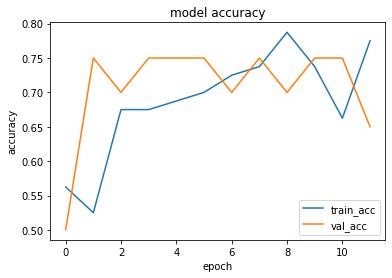

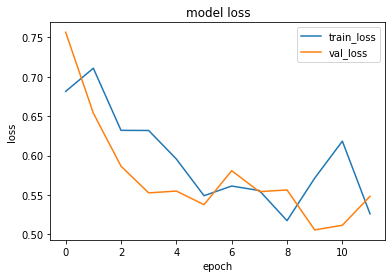

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.65044034]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_3.mov is [[0.7622359]]


1it [00:00, 16710.37it/s]


prediction for video armflapping_2.mov is [[0.7024589]]


1it [00:00, 16644.06it/s]


prediction for video control_1.mov is [[0.347224]]


1it [00:00, 14463.12it/s]


prediction for video control_2.mov is [[0.25528705]]


1it [00:00, 11618.57it/s]


prediction for video control_3.mov is [[0.25966567]]
Epoch 1/75
3/3 [==============================] - 1s 328ms/step - loss: 0.6916 - accuracy: 0.5750 - precision_75: 0.5455 - recall_75: 0.9000 - val_loss: 0.6832 - val_accuracy: 0.6000 - val_precision_75: 1.0000 - val_recall_75: 0.2000
Epoch 2/75
3/3 [==============================] - 1s 349ms/step - loss: 0.6580 - accuracy: 0.6125 - precision_75: 0.7647 - recall_75: 0.3250 - val_loss: 0.6753 - val_accuracy: 0.7000 - val_precision_75: 0.6667 - val_recall_75: 0.8000
Epoch 3/75
3/3 [==============================] - 1s 290ms/step - loss: 0.5707 - accuracy: 0.7250 - precision_75: 0.6875 - recall_75: 0.8250 - val_loss: 0.6967 - val_accuracy: 0.6500 - val_precision_75: 0.6154 - val_recall_75: 0.8000
Epoch 4/75
3/3 [==============================] - 1s 296ms/step - loss: 0.5583 - accuracy: 0.7250 - precision_75: 0.7045 - recall_75: 0.7750 - val_loss: 0.6957 - val_accuracy: 0.6000 - val_precision_75: 0.6000 - val_recall_75: 0.6000
Epoch 5/75


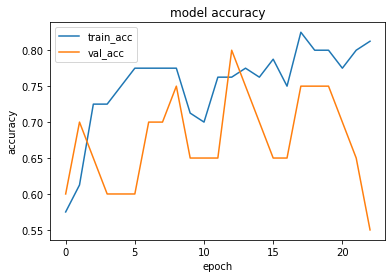

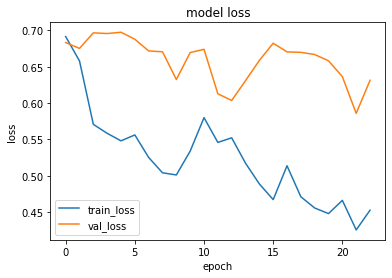

1it [00:00, 13706.88it/s]


prediction for video armflapping_1.mov is [[0.35219777]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_3.mov is [[0.3313166]]


1it [00:00, 14315.03it/s]


prediction for video armflapping_2.mov is [[0.70725536]]


1it [00:00, 15087.42it/s]


prediction for video control_1.mov is [[0.26397252]]


1it [00:00, 18236.10it/s]


prediction for video control_2.mov is [[0.25694156]]


1it [00:00, 17331.83it/s]


prediction for video control_3.mov is [[0.25364166]]
Epoch 1/75
3/3 [==============================] - 1s 303ms/step - loss: 0.7751 - accuracy: 0.5375 - precision_76: 0.5254 - recall_76: 0.7750 - val_loss: 0.6956 - val_accuracy: 0.6500 - val_precision_76: 0.6154 - val_recall_76: 0.8000
Epoch 2/75
3/3 [==============================] - 1s 295ms/step - loss: 0.6622 - accuracy: 0.6625 - precision_76: 0.6512 - recall_76: 0.7000 - val_loss: 0.6609 - val_accuracy: 0.7000 - val_precision_76: 0.7000 - val_recall_76: 0.7000
Epoch 3/75
3/3 [==============================] - 1s 429ms/step - loss: 0.6561 - accuracy: 0.7000 - precision_76: 0.8333 - recall_76: 0.5000 - val_loss: 0.6152 - val_accuracy: 0.7000 - val_precision_76: 0.7000 - val_recall_76: 0.7000
Epoch 4/75
3/3 [==============================] - 1s 309ms/step - loss: 0.6316 - accuracy: 0.6750 - precision_76: 0.7188 - recall_76: 0.5750 - val_loss: 0.5695 - val_accuracy: 0.7000 - val_precision_76: 0.6667 - val_recall_76: 0.8000
Epoch 5/75


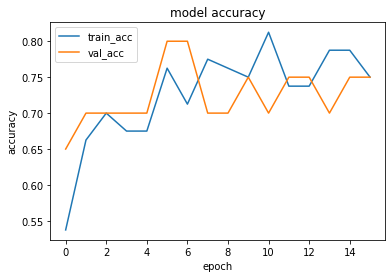

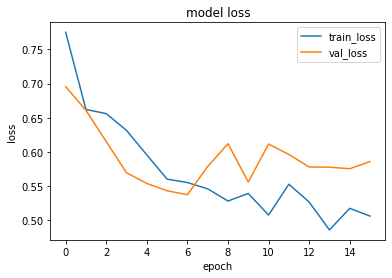

1it [00:00, 15887.52it/s]


prediction for video armflapping_1.mov is [[0.32756442]]


1it [00:00, 15196.75it/s]


prediction for video armflapping_3.mov is [[0.79623365]]


1it [00:00, 13888.42it/s]


prediction for video armflapping_2.mov is [[0.7964578]]


1it [00:00, 14513.16it/s]


prediction for video control_1.mov is [[0.21564484]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.20955276]]


1it [00:00, 15592.21it/s]


prediction for video control_3.mov is [[0.16007388]]
Epoch 1/75
3/3 [==============================] - 1s 305ms/step - loss: 0.6918 - accuracy: 0.5625 - precision_77: 0.5455 - recall_77: 0.7500 - val_loss: 0.6782 - val_accuracy: 0.5000 - val_precision_77: 0.0000e+00 - val_recall_77: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 1s 348ms/step - loss: 0.6217 - accuracy: 0.7375 - precision_77: 0.7317 - recall_77: 0.7500 - val_loss: 0.5754 - val_accuracy: 0.7500 - val_precision_77: 0.7273 - val_recall_77: 0.8000
Epoch 3/75
3/3 [==============================] - 1s 291ms/step - loss: 0.6189 - accuracy: 0.6500 - precision_77: 0.6364 - recall_77: 0.7000 - val_loss: 0.5585 - val_accuracy: 0.7000 - val_precision_77: 0.7000 - val_recall_77: 0.7000
Epoch 4/75
3/3 [==============================] - 1s 294ms/step - loss: 0.5927 - accuracy: 0.7125 - precision_77: 0.7073 - recall_77: 0.7250 - val_loss: 0.5692 - val_accuracy: 0.7500 - val_precision_77: 0.7778 - val_recall_77: 0.7000
Epo

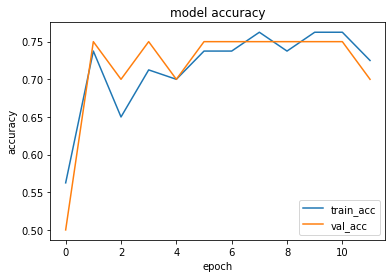

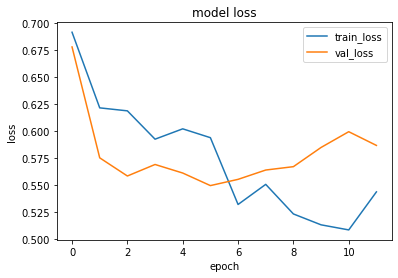

1it [00:00, 15363.75it/s]


prediction for video armflapping_1.mov is [[0.2647636]]


1it [00:00, 16448.25it/s]


prediction for video armflapping_3.mov is [[0.5957544]]


1it [00:00, 15827.56it/s]


prediction for video armflapping_2.mov is [[0.631736]]


1it [00:00, 14315.03it/s]


prediction for video control_1.mov is [[0.15658057]]


1it [00:00, 15650.39it/s]


prediction for video control_2.mov is [[0.1426023]]


1it [00:00, 14463.12it/s]


prediction for video control_3.mov is [[0.14045101]]


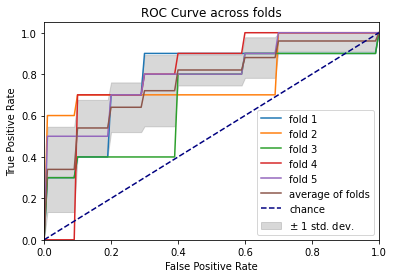

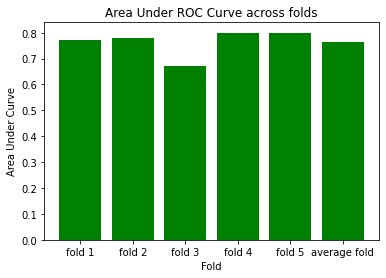

In [181]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 1s 296ms/step - loss: 0.7137 - accuracy: 0.6125 - precision_79: 0.6957 - recall_79: 0.4000 - val_loss: 0.7765 - val_accuracy: 0.5000 - val_precision_79: 0.5000 - val_recall_79: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 295ms/step - loss: 0.6735 - accuracy: 0.5875 - precision_79: 0.5522 - recall_79: 0.9250 - val_loss: 0.7019 - val_accuracy: 0.6500 - val_precision_79: 0.6364 - val_recall_79: 0.7000
Epoch 3/75
3/3 [==============================] - 1s 312ms/step - loss: 0.6210 - accuracy: 0.7125 - precision_79: 0.7073 - recall_79: 0.7250 - val_loss: 0.6690 - val_accuracy: 0.6500 - val_precision_79: 0.6364 - val_recall_79: 0.7000
Epoch 4/75
3/3 [==============================] - 1s 361ms/step - loss: 0.5924 - accuracy: 0.7125 - precision_79: 0.7297 - recall_79: 0.6750 - val_loss: 0.5862 - val_accuracy: 0.8500 - val_precision_79: 0.8182 - val_recall_79: 0.9000
Epoch 5/75
3/3 [==============================] - 1s 306ms/step 

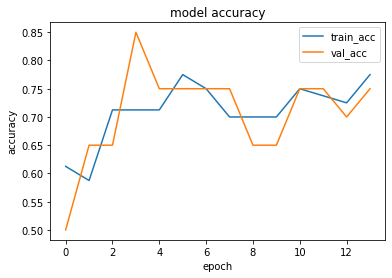

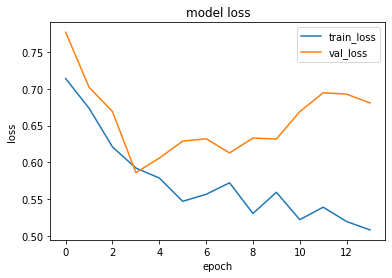

1it [00:00, 14665.40it/s]


prediction for video armflapping_1.mov is [[0.39411578]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_3.mov is [[0.559003]]


1it [00:00, 14266.34it/s]


prediction for video armflapping_2.mov is [[0.6707678]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.1755794]]


1it [00:00, 16980.99it/s]


prediction for video control_2.mov is [[0.15197921]]


1it [00:00, 16131.94it/s]


prediction for video control_3.mov is [[0.18493092]]
Epoch 1/75
3/3 [==============================] - 1s 327ms/step - loss: 0.6967 - accuracy: 0.4750 - precision_80: 0.4821 - recall_80: 0.6750 - val_loss: 0.6707 - val_accuracy: 0.5500 - val_precision_80: 0.6667 - val_recall_80: 0.2000
Epoch 2/75
3/3 [==============================] - 1s 317ms/step - loss: 0.6699 - accuracy: 0.6000 - precision_80: 0.6333 - recall_80: 0.4750 - val_loss: 0.6089 - val_accuracy: 0.6000 - val_precision_80: 0.5625 - val_recall_80: 0.9000
Epoch 3/75
3/3 [==============================] - 1s 328ms/step - loss: 0.6553 - accuracy: 0.7125 - precision_80: 0.6604 - recall_80: 0.8750 - val_loss: 0.5219 - val_accuracy: 0.8500 - val_precision_80: 0.8182 - val_recall_80: 0.9000
Epoch 4/75
3/3 [==============================] - 1s 325ms/step - loss: 0.6359 - accuracy: 0.6875 - precision_80: 0.7419 - recall_80: 0.5750 - val_loss: 0.5508 - val_accuracy: 0.8000 - val_precision_80: 0.8750 - val_recall_80: 0.7000
Epoch 5/75


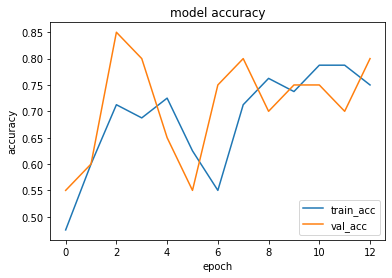

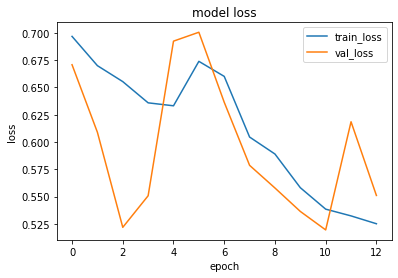

1it [00:00, 14716.86it/s]


prediction for video armflapping_1.mov is [[0.32850248]]


1it [00:00, 13888.42it/s]


prediction for video armflapping_3.mov is [[0.380094]]


1it [00:00, 16710.37it/s]


prediction for video armflapping_2.mov is [[0.35504472]]


1it [00:00, 14027.77it/s]


prediction for video control_1.mov is [[0.3202083]]


1it [00:00, 14513.16it/s]


prediction for video control_2.mov is [[0.31813633]]


1it [00:00, 17848.10it/s]


prediction for video control_3.mov is [[0.3181554]]
Epoch 1/75
3/3 [==============================] - 1s 306ms/step - loss: 0.6870 - accuracy: 0.5000 - precision_81: 0.5000 - recall_81: 0.6250 - val_loss: 0.6750 - val_accuracy: 0.7500 - val_precision_81: 0.7778 - val_recall_81: 0.7000
Epoch 2/75
3/3 [==============================] - 1s 351ms/step - loss: 0.6178 - accuracy: 0.6750 - precision_81: 0.6400 - recall_81: 0.8000 - val_loss: 0.6712 - val_accuracy: 0.6500 - val_precision_81: 0.7143 - val_recall_81: 0.5000
Epoch 3/75
3/3 [==============================] - 1s 294ms/step - loss: 0.5897 - accuracy: 0.7250 - precision_81: 0.7368 - recall_81: 0.7000 - val_loss: 0.8111 - val_accuracy: 0.6000 - val_precision_81: 0.6667 - val_recall_81: 0.4000
Epoch 4/75
3/3 [==============================] - 1s 317ms/step - loss: 0.6228 - accuracy: 0.6875 - precision_81: 0.7419 - recall_81: 0.5750 - val_loss: 0.6971 - val_accuracy: 0.5500 - val_precision_81: 0.5556 - val_recall_81: 0.5000
Epoch 5/75
3

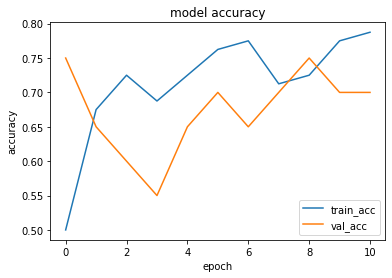

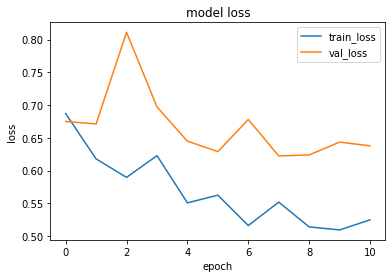

1it [00:00, 14513.16it/s]


prediction for video armflapping_1.mov is [[0.50370425]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_3.mov is [[0.38999173]]


1it [00:00, 13706.88it/s]


prediction for video armflapping_2.mov is [[0.5699554]]


1it [00:00, 18558.87it/s]


prediction for video control_1.mov is [[0.43775198]]


1it [00:00, 16194.22it/s]


prediction for video control_2.mov is [[0.39008042]]


1it [00:00, 17848.10it/s]


prediction for video control_3.mov is [[0.40000546]]
Epoch 1/75
3/3 [==============================] - 1s 300ms/step - loss: 0.7058 - accuracy: 0.4625 - precision_82: 0.4717 - recall_82: 0.6250 - val_loss: 0.6294 - val_accuracy: 0.6000 - val_precision_82: 0.5556 - val_recall_82: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 294ms/step - loss: 0.6663 - accuracy: 0.6125 - precision_82: 0.5714 - recall_82: 0.9000 - val_loss: 0.5829 - val_accuracy: 0.7500 - val_precision_82: 0.6923 - val_recall_82: 0.9000
Epoch 3/75
3/3 [==============================] - 1s 311ms/step - loss: 0.6107 - accuracy: 0.7250 - precision_82: 0.7647 - recall_82: 0.6500 - val_loss: 0.5673 - val_accuracy: 0.8000 - val_precision_82: 0.8000 - val_recall_82: 0.8000
Epoch 4/75
3/3 [==============================] - 1s 295ms/step - loss: 0.6069 - accuracy: 0.6875 - precision_82: 0.7778 - recall_82: 0.5250 - val_loss: 0.5803 - val_accuracy: 0.7000 - val_precision_82: 0.6667 - val_recall_82: 0.8000
Epoch 5/75


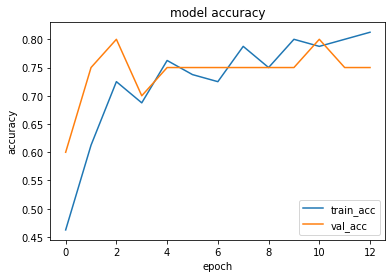

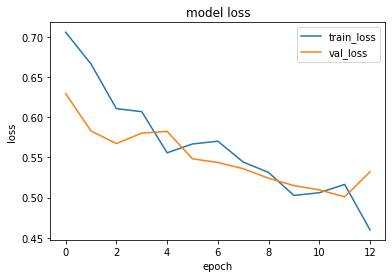

1it [00:00, 15363.75it/s]


prediction for video armflapping_1.mov is [[0.40279427]]


1it [00:00, 16384.00it/s]


prediction for video armflapping_3.mov is [[0.36806953]]


1it [00:00, 14074.85it/s]


prediction for video armflapping_2.mov is [[0.6946453]]


1it [00:00, 16384.00it/s]


prediction for video control_1.mov is [[0.25005218]]


1it [00:00, 15887.52it/s]


prediction for video control_2.mov is [[0.19956112]]


1it [00:00, 13706.88it/s]


prediction for video control_3.mov is [[0.19792557]]
Epoch 1/75
3/3 [==============================] - 1s 327ms/step - loss: 0.7346 - accuracy: 0.5500 - precision_83: 0.5385 - recall_83: 0.7000 - val_loss: 0.6601 - val_accuracy: 0.6500 - val_precision_83: 0.7143 - val_recall_83: 0.5000
Epoch 2/75
3/3 [==============================] - 1s 322ms/step - loss: 0.6553 - accuracy: 0.6875 - precision_83: 0.7027 - recall_83: 0.6500 - val_loss: 0.6358 - val_accuracy: 0.5500 - val_precision_83: 0.6000 - val_recall_83: 0.3000
Epoch 3/75
3/3 [==============================] - 1s 286ms/step - loss: 0.6387 - accuracy: 0.6875 - precision_83: 0.6667 - recall_83: 0.7500 - val_loss: 0.5949 - val_accuracy: 0.7500 - val_precision_83: 0.7778 - val_recall_83: 0.7000
Epoch 4/75
3/3 [==============================] - 1s 364ms/step - loss: 0.6231 - accuracy: 0.6750 - precision_83: 0.6400 - recall_83: 0.8000 - val_loss: 0.5814 - val_accuracy: 0.7000 - val_precision_83: 0.7000 - val_recall_83: 0.7000
Epoch 5/75


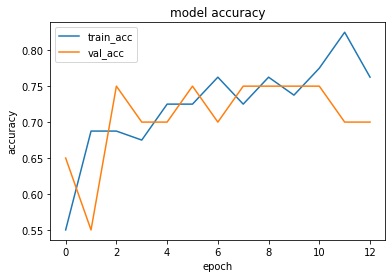

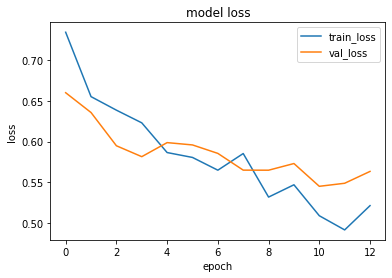

1it [00:00, 12787.51it/s]


prediction for video armflapping_1.mov is [[0.48497307]]


1it [00:00, 17189.77it/s]


prediction for video armflapping_3.mov is [[0.7579452]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_2.mov is [[0.8137549]]


1it [00:00, 17924.38it/s]


prediction for video control_1.mov is [[0.27037168]]


1it [00:00, 15650.39it/s]


prediction for video control_2.mov is [[0.22098997]]


1it [00:00, 14926.35it/s]


prediction for video control_3.mov is [[0.21807614]]


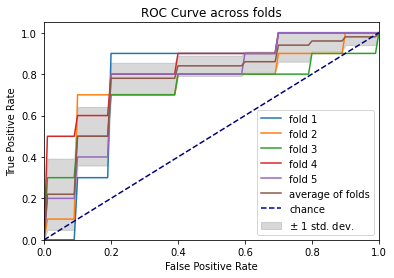

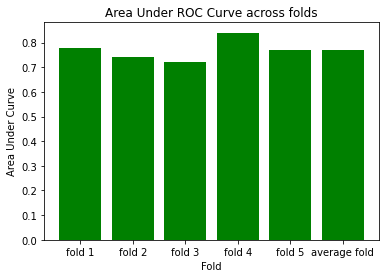

In [182]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 1s 301ms/step - loss: 0.7000 - accuracy: 0.4875 - precision_85: 0.4921 - recall_85: 0.7750 - val_loss: 0.6699 - val_accuracy: 0.5500 - val_precision_85: 0.6000 - val_recall_85: 0.3000
Epoch 2/75
3/3 [==============================] - 1s 305ms/step - loss: 0.6722 - accuracy: 0.6625 - precision_85: 0.8824 - recall_85: 0.3750 - val_loss: 0.6729 - val_accuracy: 0.7500 - val_precision_85: 0.6923 - val_recall_85: 0.9000
Epoch 3/75
3/3 [==============================] - 1s 301ms/step - loss: 0.6564 - accuracy: 0.7000 - precision_85: 0.6667 - recall_85: 0.8000 - val_loss: 0.7135 - val_accuracy: 0.7000 - val_precision_85: 0.6429 - val_recall_85: 0.9000
Epoch 4/75
3/3 [==============================] - 1s 353ms/step - loss: 0.6049 - accuracy: 0.7375 - precision_85: 0.7317 - recall_85: 0.7500 - val_loss: 0.6886 - val_accuracy: 0.6500 - val_precision_85: 0.6364 - val_recall_85: 0.7000
Epoch 5/75
3/3 [==============================] - 1s 314ms/step 

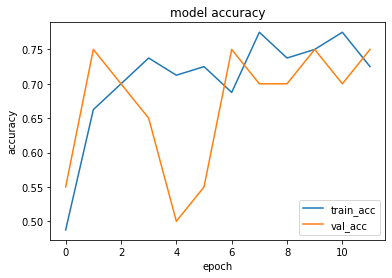

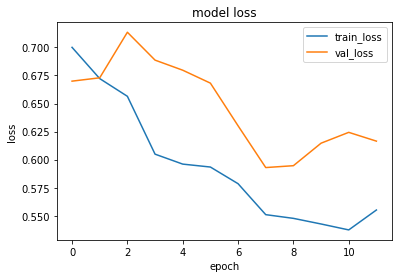

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.50180334]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_3.mov is [[0.54710007]]


1it [00:00, 14122.24it/s]


prediction for video armflapping_2.mov is [[0.5335981]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.4807599]]


1it [00:00, 15887.52it/s]


prediction for video control_2.mov is [[0.4767758]]


1it [00:00, 15252.01it/s]


prediction for video control_3.mov is [[0.47521985]]
Epoch 1/75
3/3 [==============================] - 1s 310ms/step - loss: 0.6857 - accuracy: 0.4500 - precision_86: 0.4677 - recall_86: 0.7250 - val_loss: 0.7104 - val_accuracy: 0.7000 - val_precision_86: 0.8333 - val_recall_86: 0.5000
Epoch 2/75
3/3 [==============================] - 1s 332ms/step - loss: 0.6716 - accuracy: 0.6125 - precision_86: 0.6286 - recall_86: 0.5500 - val_loss: 0.5897 - val_accuracy: 0.6000 - val_precision_86: 0.5714 - val_recall_86: 0.8000
Epoch 3/75
3/3 [==============================] - 1s 326ms/step - loss: 0.6275 - accuracy: 0.6875 - precision_86: 0.6415 - recall_86: 0.8500 - val_loss: 0.5749 - val_accuracy: 0.7500 - val_precision_86: 0.7273 - val_recall_86: 0.8000
Epoch 4/75
3/3 [==============================] - 1s 360ms/step - loss: 0.6216 - accuracy: 0.7375 - precision_86: 0.7021 - recall_86: 0.8250 - val_loss: 0.6040 - val_accuracy: 0.8000 - val_precision_86: 0.8750 - val_recall_86: 0.7000
Epoch 5/75


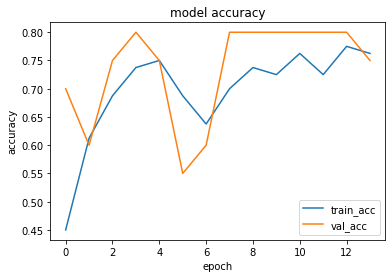

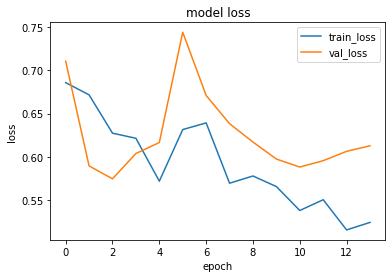

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.48938224]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.50684047]]


1it [00:00, 14027.77it/s]


prediction for video armflapping_2.mov is [[0.57891893]]


1it [00:00, 14074.85it/s]


prediction for video control_1.mov is [[0.44335592]]


1it [00:00, 15887.52it/s]


prediction for video control_2.mov is [[0.42550427]]


1it [00:00, 18893.26it/s]


prediction for video control_3.mov is [[0.4165316]]
Epoch 1/75
3/3 [==============================] - 1s 308ms/step - loss: 0.6801 - accuracy: 0.7000 - precision_87: 0.7353 - recall_87: 0.6250 - val_loss: 0.6766 - val_accuracy: 0.5000 - val_precision_87: 0.5000 - val_recall_87: 0.8000
Epoch 2/75
3/3 [==============================] - 1s 313ms/step - loss: 0.6027 - accuracy: 0.6625 - precision_87: 0.6066 - recall_87: 0.9250 - val_loss: 0.7208 - val_accuracy: 0.7000 - val_precision_87: 0.6667 - val_recall_87: 0.8000
Epoch 3/75
3/3 [==============================] - 1s 318ms/step - loss: 0.5757 - accuracy: 0.7125 - precision_87: 0.6809 - recall_87: 0.8000 - val_loss: 0.6688 - val_accuracy: 0.6500 - val_precision_87: 0.6667 - val_recall_87: 0.6000
Epoch 4/75
3/3 [==============================] - 1s 319ms/step - loss: 0.6298 - accuracy: 0.6875 - precision_87: 0.6923 - recall_87: 0.6750 - val_loss: 0.6613 - val_accuracy: 0.6000 - val_precision_87: 0.6250 - val_recall_87: 0.5000
Epoch 5/75
3

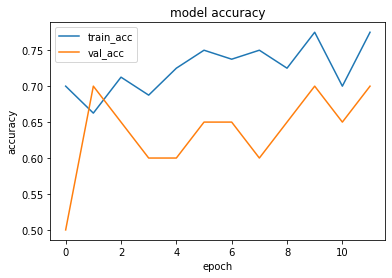

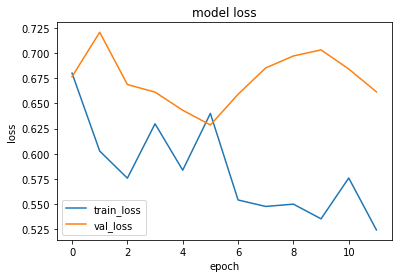

1it [00:00, 14716.86it/s]


prediction for video armflapping_1.mov is [[0.41884694]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_3.mov is [[0.4428407]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_2.mov is [[0.5766436]]


1it [00:00, 14027.77it/s]


prediction for video control_1.mov is [[0.31687105]]


1it [00:00, 14463.12it/s]


prediction for video control_2.mov is [[0.29504582]]


1it [00:00, 17772.47it/s]


prediction for video control_3.mov is [[0.28925413]]
Epoch 1/75
3/3 [==============================] - 1s 306ms/step - loss: 0.7257 - accuracy: 0.5000 - precision_88: 0.5000 - recall_88: 0.4000 - val_loss: 0.6149 - val_accuracy: 0.7000 - val_precision_88: 0.6429 - val_recall_88: 0.9000
Epoch 2/75
3/3 [==============================] - 1s 303ms/step - loss: 0.6658 - accuracy: 0.6500 - precision_88: 0.6034 - recall_88: 0.8750 - val_loss: 0.6226 - val_accuracy: 0.7000 - val_precision_88: 0.6429 - val_recall_88: 0.9000
Epoch 3/75
3/3 [==============================] - 1s 295ms/step - loss: 0.6369 - accuracy: 0.7000 - precision_88: 0.6481 - recall_88: 0.8750 - val_loss: 0.5967 - val_accuracy: 0.7500 - val_precision_88: 0.7273 - val_recall_88: 0.8000
Epoch 4/75
3/3 [==============================] - 1s 293ms/step - loss: 0.6327 - accuracy: 0.6500 - precision_88: 0.6875 - recall_88: 0.5500 - val_loss: 0.6017 - val_accuracy: 0.7000 - val_precision_88: 0.7500 - val_recall_88: 0.6000
Epoch 5/75


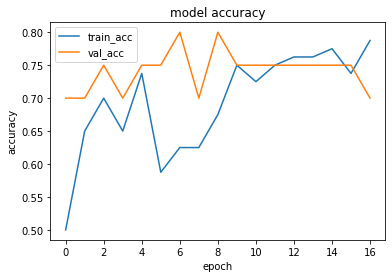

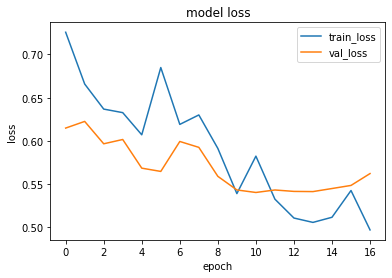

1it [00:00, 15363.75it/s]


prediction for video armflapping_1.mov is [[0.6304437]]


1it [00:00, 13662.23it/s]


prediction for video armflapping_3.mov is [[0.33484322]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_2.mov is [[0.68245745]]


1it [00:00, 14926.35it/s]


prediction for video control_1.mov is [[0.5059183]]


1it [00:00, 15887.52it/s]


prediction for video control_2.mov is [[0.28465912]]


1it [00:00, 13315.25it/s]


prediction for video control_3.mov is [[0.28360796]]
Epoch 1/75
3/3 [==============================] - 1s 310ms/step - loss: 0.6647 - accuracy: 0.6125 - precision_89: 0.6552 - recall_89: 0.4750 - val_loss: 0.5688 - val_accuracy: 0.6000 - val_precision_89: 0.5556 - val_recall_89: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 311ms/step - loss: 0.6906 - accuracy: 0.6125 - precision_89: 0.5957 - recall_89: 0.7000 - val_loss: 0.5833 - val_accuracy: 0.7500 - val_precision_89: 0.7778 - val_recall_89: 0.7000
Epoch 3/75
3/3 [==============================] - 1s 296ms/step - loss: 0.6385 - accuracy: 0.7125 - precision_89: 0.6889 - recall_89: 0.7750 - val_loss: 0.5957 - val_accuracy: 0.7000 - val_precision_89: 0.7500 - val_recall_89: 0.6000
Epoch 4/75
3/3 [==============================] - 1s 362ms/step - loss: 0.5908 - accuracy: 0.7250 - precision_89: 0.7143 - recall_89: 0.7500 - val_loss: 0.5643 - val_accuracy: 0.7500 - val_precision_89: 0.7778 - val_recall_89: 0.7000
Epoch 5/75


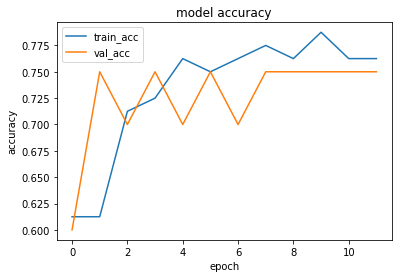

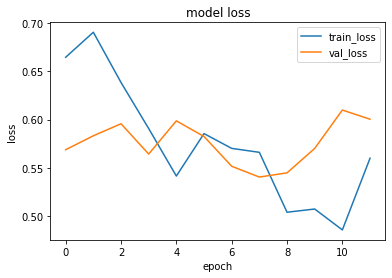

1it [00:00, 14074.85it/s]


prediction for video armflapping_1.mov is [[0.64091045]]


1it [00:00, 15592.21it/s]


prediction for video armflapping_3.mov is [[0.7745342]]


1it [00:00, 13357.66it/s]


prediction for video armflapping_2.mov is [[0.759295]]


1it [00:00, 18558.87it/s]


prediction for video control_1.mov is [[0.12970799]]


1it [00:00, 15827.56it/s]


prediction for video control_2.mov is [[0.1261617]]


1it [00:00, 14122.24it/s]

prediction for video control_3.mov is [[0.12538275]]


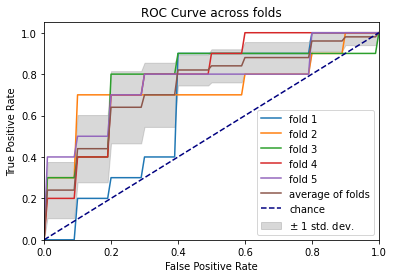

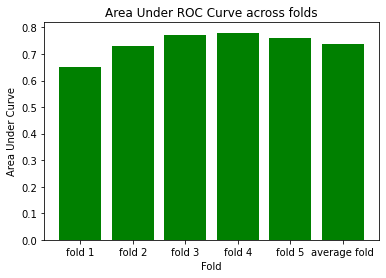

In [183]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 1s 305ms/step - loss: 0.6906 - accuracy: 0.5875 - precision_91: 0.5660 - recall_91: 0.7500 - val_loss: 0.6911 - val_accuracy: 0.5500 - val_precision_91: 0.5263 - val_recall_91: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 355ms/step - loss: 0.6121 - accuracy: 0.5750 - precision_91: 0.5455 - recall_91: 0.9000 - val_loss: 0.7603 - val_accuracy: 0.6000 - val_precision_91: 0.5625 - val_recall_91: 0.9000
Epoch 3/75
3/3 [==============================] - 1s 287ms/step - loss: 0.5783 - accuracy: 0.7125 - precision_91: 0.6809 - recall_91: 0.8000 - val_loss: 0.7495 - val_accuracy: 0.6500 - val_precision_91: 0.6000 - val_recall_91: 0.9000
Epoch 4/75
3/3 [==============================] - 1s 289ms/step - loss: 0.5503 - accuracy: 0.7500 - precision_91: 0.7500 - recall_91: 0.7500 - val_loss: 0.5843 - val_accuracy: 0.7500 - val_precision_91: 0.7273 - val_recall_91: 0.8000
Epoch 5/75
3/3 [==============================] - 1s 296ms/step 

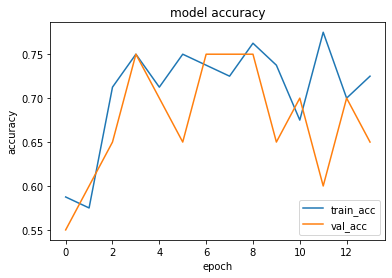

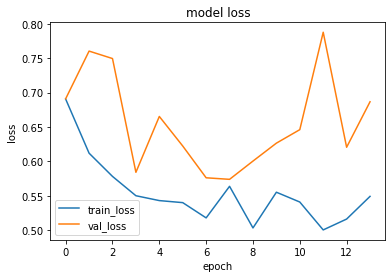

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.4803662]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_3.mov is [[0.578704]]


1it [00:00, 16070.13it/s]


prediction for video armflapping_2.mov is [[0.6017588]]


1it [00:00, 17189.77it/s]


prediction for video control_1.mov is [[0.40924576]]


1it [00:00, 15141.89it/s]


prediction for video control_2.mov is [[0.37531754]]


1it [00:00, 15141.89it/s]


prediction for video control_3.mov is [[0.34259272]]
Epoch 1/75
3/3 [==============================] - 1s 323ms/step - loss: 0.6960 - accuracy: 0.5375 - precision_92: 0.5333 - recall_92: 0.6000 - val_loss: 0.6162 - val_accuracy: 0.8500 - val_precision_92: 0.8889 - val_recall_92: 0.8000
Epoch 2/75
3/3 [==============================] - 1s 315ms/step - loss: 0.6570 - accuracy: 0.6000 - precision_92: 0.5667 - recall_92: 0.8500 - val_loss: 0.6922 - val_accuracy: 0.5500 - val_precision_92: 0.5385 - val_recall_92: 0.7000
Epoch 3/75
3/3 [==============================] - 1s 373ms/step - loss: 0.6188 - accuracy: 0.7125 - precision_92: 0.6889 - recall_92: 0.7750 - val_loss: 0.6311 - val_accuracy: 0.7500 - val_precision_92: 0.8571 - val_recall_92: 0.6000
Epoch 4/75
3/3 [==============================] - 1s 310ms/step - loss: 0.6218 - accuracy: 0.6750 - precision_92: 0.6944 - recall_92: 0.6250 - val_loss: 0.6827 - val_accuracy: 0.7500 - val_precision_92: 1.0000 - val_recall_92: 0.5000
Epoch 5/75


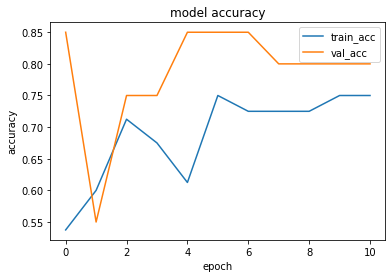

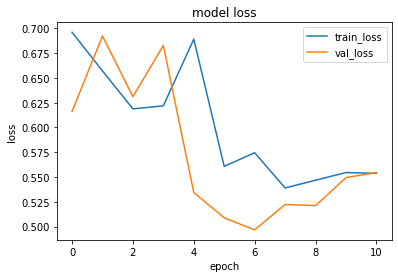

1it [00:00, 14513.16it/s]


prediction for video armflapping_1.mov is [[0.5104362]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_3.mov is [[0.53839815]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_2.mov is [[0.5278277]]


1it [00:00, 15592.21it/s]


prediction for video control_1.mov is [[0.49895063]]


1it [00:00, 15887.52it/s]


prediction for video control_2.mov is [[0.4950662]]


1it [00:00, 14122.24it/s]


prediction for video control_3.mov is [[0.4937079]]
Epoch 1/75
3/3 [==============================] - 1s 317ms/step - loss: 0.7379 - accuracy: 0.4500 - precision_93: 0.4412 - recall_93: 0.3750 - val_loss: 0.6843 - val_accuracy: 0.7000 - val_precision_93: 0.7000 - val_recall_93: 0.7000
Epoch 2/75
3/3 [==============================] - 1s 377ms/step - loss: 0.6340 - accuracy: 0.6875 - precision_93: 0.6596 - recall_93: 0.7750 - val_loss: 0.6854 - val_accuracy: 0.6500 - val_precision_93: 0.7143 - val_recall_93: 0.5000
Epoch 3/75
3/3 [==============================] - 1s 318ms/step - loss: 0.6085 - accuracy: 0.7250 - precision_93: 0.7500 - recall_93: 0.6750 - val_loss: 0.6832 - val_accuracy: 0.7000 - val_precision_93: 0.7500 - val_recall_93: 0.6000
Epoch 4/75
3/3 [==============================] - 1s 315ms/step - loss: 0.6056 - accuracy: 0.7375 - precision_93: 0.7209 - recall_93: 0.7750 - val_loss: 0.7278 - val_accuracy: 0.6500 - val_precision_93: 0.6667 - val_recall_93: 0.6000
Epoch 5/75
3

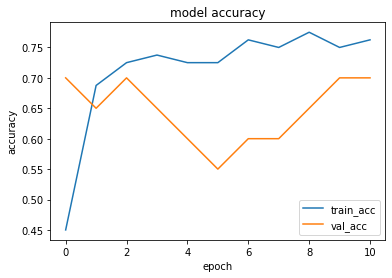

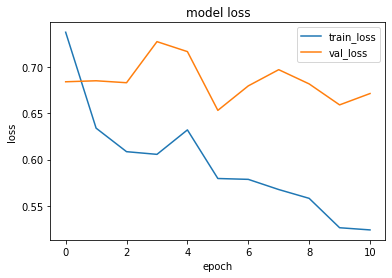

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.33948883]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.6785295]]


1it [00:00, 14217.98it/s]


prediction for video armflapping_2.mov is [[0.7132117]]


1it [00:00, 14873.42it/s]


prediction for video control_1.mov is [[0.19786876]]


1it [00:00, 14463.12it/s]


prediction for video control_2.mov is [[0.191681]]


1it [00:00, 15363.75it/s]


prediction for video control_3.mov is [[0.19620642]]
Epoch 1/75
3/3 [==============================] - 1s 362ms/step - loss: 0.6796 - accuracy: 0.6125 - precision_94: 0.6286 - recall_94: 0.5500 - val_loss: 0.6321 - val_accuracy: 0.7000 - val_precision_94: 0.6429 - val_recall_94: 0.9000
Epoch 2/75
3/3 [==============================] - 1s 296ms/step - loss: 0.6492 - accuracy: 0.6750 - precision_94: 0.6250 - recall_94: 0.8750 - val_loss: 0.5761 - val_accuracy: 0.7500 - val_precision_94: 0.7778 - val_recall_94: 0.7000
Epoch 3/75
3/3 [==============================] - 1s 291ms/step - loss: 0.6203 - accuracy: 0.7125 - precision_94: 0.8148 - recall_94: 0.5500 - val_loss: 0.5490 - val_accuracy: 0.7000 - val_precision_94: 0.7000 - val_recall_94: 0.7000
Epoch 4/75
3/3 [==============================] - 1s 291ms/step - loss: 0.5567 - accuracy: 0.7375 - precision_94: 0.7714 - recall_94: 0.6750 - val_loss: 0.6132 - val_accuracy: 0.7000 - val_precision_94: 0.6667 - val_recall_94: 0.8000
Epoch 5/75


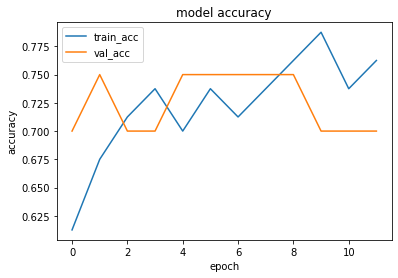

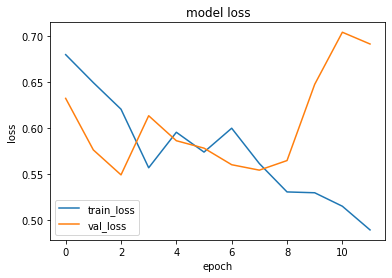

1it [00:00, 13486.51it/s]


prediction for video armflapping_1.mov is [[0.2175326]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_3.mov is [[0.50764936]]


1it [00:00, 12787.51it/s]


prediction for video armflapping_2.mov is [[0.5768025]]


1it [00:00, 13706.88it/s]


prediction for video control_1.mov is [[0.2013877]]


1it [00:00, 20460.02it/s]


prediction for video control_2.mov is [[0.19646472]]


1it [00:00, 14266.34it/s]


prediction for video control_3.mov is [[0.19588]]
Epoch 1/75
3/3 [==============================] - 1s 312ms/step - loss: 0.6925 - accuracy: 0.5250 - precision_95: 0.5556 - recall_95: 0.2500 - val_loss: 0.6873 - val_accuracy: 0.5500 - val_precision_95: 0.5333 - val_recall_95: 0.8000
Epoch 2/75
3/3 [==============================] - 1s 301ms/step - loss: 0.7010 - accuracy: 0.6500 - precision_95: 0.6034 - recall_95: 0.8750 - val_loss: 0.6433 - val_accuracy: 0.7000 - val_precision_95: 0.7500 - val_recall_95: 0.6000
Epoch 3/75
3/3 [==============================] - 1s 351ms/step - loss: 0.6479 - accuracy: 0.6875 - precision_95: 0.6923 - recall_95: 0.6750 - val_loss: 0.6340 - val_accuracy: 0.6000 - val_precision_95: 0.7500 - val_recall_95: 0.3000
Epoch 4/75
3/3 [==============================] - 1s 296ms/step - loss: 0.6359 - accuracy: 0.6750 - precision_95: 0.7059 - recall_95: 0.6000 - val_loss: 0.5830 - val_accuracy: 0.7000 - val_precision_95: 0.7500 - val_recall_95: 0.6000
Epoch 5/75
3/3

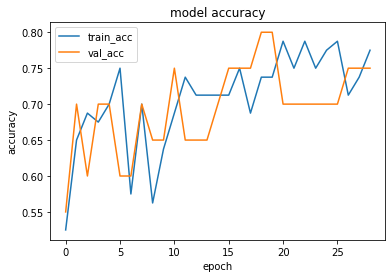

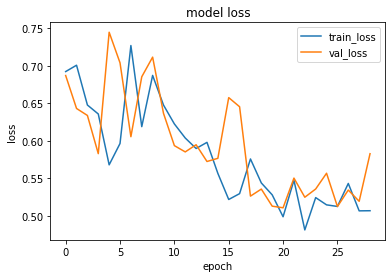

1it [00:00, 13315.25it/s]


prediction for video armflapping_1.mov is [[0.40751055]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_3.mov is [[0.67234415]]


1it [00:00, 11881.88it/s]


prediction for video armflapping_2.mov is [[0.76669294]]


1it [00:00, 15363.75it/s]


prediction for video control_1.mov is [[0.28144276]]


1it [00:00, 15650.39it/s]


prediction for video control_2.mov is [[0.25280172]]


1it [00:00, 15363.75it/s]


prediction for video control_3.mov is [[0.29512787]]


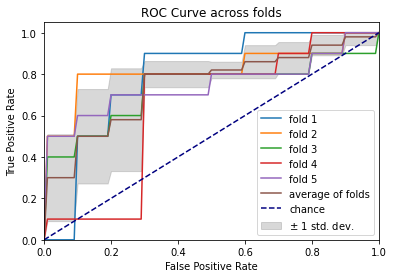

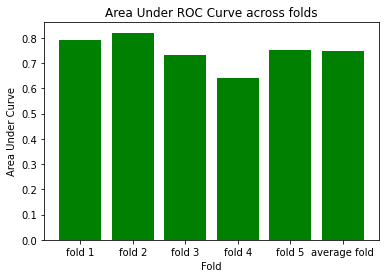

In [184]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 1s 305ms/step - loss: 0.6908 - accuracy: 0.4625 - precision_97: 0.4776 - recall_97: 0.8000 - val_loss: 0.6611 - val_accuracy: 0.6500 - val_precision_97: 0.6667 - val_recall_97: 0.6000
Epoch 2/75
3/3 [==============================] - 1s 287ms/step - loss: 0.6257 - accuracy: 0.7250 - precision_97: 0.8000 - recall_97: 0.6000 - val_loss: 0.6951 - val_accuracy: 0.6500 - val_precision_97: 0.6000 - val_recall_97: 0.9000
Epoch 3/75
3/3 [==============================] - 1s 301ms/step - loss: 0.6352 - accuracy: 0.7000 - precision_97: 0.6538 - recall_97: 0.8500 - val_loss: 0.7376 - val_accuracy: 0.6500 - val_precision_97: 0.6364 - val_recall_97: 0.7000
Epoch 4/75
3/3 [==============================] - 1s 382ms/step - loss: 0.5951 - accuracy: 0.7000 - precision_97: 0.7222 - recall_97: 0.6500 - val_loss: 0.6616 - val_accuracy: 0.6000 - val_precision_97: 0.6250 - val_recall_97: 0.5000
Epoch 5/75
3/3 [==============================] - 1s 290ms/step 

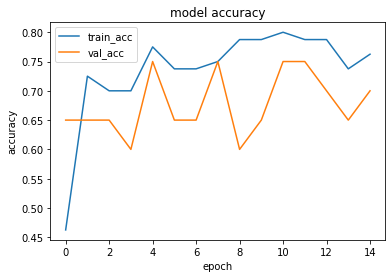

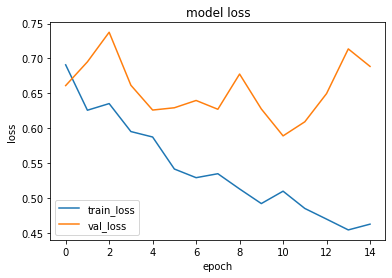

1it [00:00, 13934.56it/s]


prediction for video armflapping_1.mov is [[0.43009362]]


1it [00:00, 14266.34it/s]


prediction for video armflapping_3.mov is [[0.53793335]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_2.mov is [[0.5863358]]


1it [00:00, 14716.86it/s]


prediction for video control_1.mov is [[0.31523234]]


1it [00:00, 15592.21it/s]


prediction for video control_2.mov is [[0.28429168]]


1it [00:00, 14979.66it/s]


prediction for video control_3.mov is [[0.261078]]
Epoch 1/75
3/3 [==============================] - 1s 314ms/step - loss: 0.6911 - accuracy: 0.5500 - precision_98: 0.5556 - recall_98: 0.5000 - val_loss: 0.5943 - val_accuracy: 0.6500 - val_precision_98: 0.6154 - val_recall_98: 0.8000
Epoch 2/75
3/3 [==============================] - 1s 311ms/step - loss: 0.6336 - accuracy: 0.7000 - precision_98: 0.6538 - recall_98: 0.8500 - val_loss: 0.7564 - val_accuracy: 0.6000 - val_precision_98: 0.7500 - val_recall_98: 0.3000
Epoch 3/75
3/3 [==============================] - 1s 371ms/step - loss: 0.6298 - accuracy: 0.6375 - precision_98: 0.7619 - recall_98: 0.4000 - val_loss: 0.5903 - val_accuracy: 0.8000 - val_precision_98: 0.8750 - val_recall_98: 0.7000
Epoch 4/75
3/3 [==============================] - 1s 327ms/step - loss: 0.6071 - accuracy: 0.7125 - precision_98: 0.6735 - recall_98: 0.8250 - val_loss: 0.5498 - val_accuracy: 0.7500 - val_precision_98: 0.7273 - val_recall_98: 0.8000
Epoch 5/75
3/

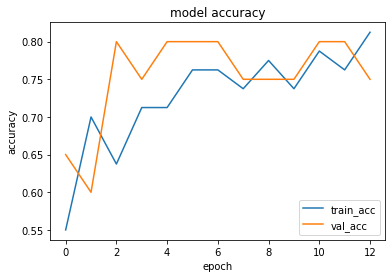

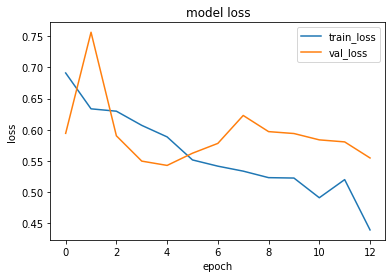

1it [00:00, 15650.39it/s]


prediction for video armflapping_1.mov is [[0.5004439]]


1it [00:00, 16644.06it/s]


prediction for video armflapping_3.mov is [[0.52920127]]


1it [00:00, 15420.24it/s]


prediction for video armflapping_2.mov is [[0.62324435]]


1it [00:00, 13706.88it/s]


prediction for video control_1.mov is [[0.43695146]]


1it [00:00, 14315.03it/s]


prediction for video control_2.mov is [[0.41004288]]


1it [00:00, 11781.75it/s]


prediction for video control_3.mov is [[0.39771947]]
Epoch 1/75
3/3 [==============================] - 1s 338ms/step - loss: 0.6809 - accuracy: 0.5500 - precision_99: 0.5455 - recall_99: 0.6000 - val_loss: 0.7148 - val_accuracy: 0.7500 - val_precision_99: 0.6923 - val_recall_99: 0.9000
Epoch 2/75
3/3 [==============================] - 1s 325ms/step - loss: 0.6370 - accuracy: 0.6625 - precision_99: 0.6585 - recall_99: 0.6750 - val_loss: 0.6809 - val_accuracy: 0.6000 - val_precision_99: 0.6250 - val_recall_99: 0.5000
Epoch 3/75
3/3 [==============================] - 1s 313ms/step - loss: 0.5719 - accuracy: 0.7375 - precision_99: 0.7436 - recall_99: 0.7250 - val_loss: 0.6709 - val_accuracy: 0.6000 - val_precision_99: 0.6000 - val_recall_99: 0.6000
Epoch 4/75
3/3 [==============================] - 1s 380ms/step - loss: 0.5717 - accuracy: 0.7750 - precision_99: 0.7619 - recall_99: 0.8000 - val_loss: 0.6848 - val_accuracy: 0.6000 - val_precision_99: 0.6000 - val_recall_99: 0.6000
Epoch 5/75


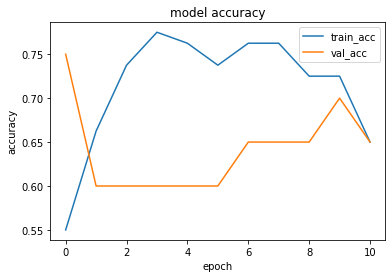

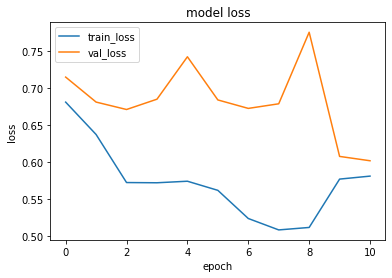

1it [00:00, 14665.40it/s]


prediction for video armflapping_1.mov is [[0.4410303]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_3.mov is [[0.42415413]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_2.mov is [[0.5402528]]


1it [00:00, 14716.86it/s]


prediction for video control_1.mov is [[0.27213788]]


1it [00:00, 15141.89it/s]


prediction for video control_2.mov is [[0.24987122]]


1it [00:00, 13530.01it/s]


prediction for video control_3.mov is [[0.23924178]]
Epoch 1/75
3/3 [==============================] - 1s 309ms/step - loss: 0.7009 - accuracy: 0.4750 - precision_100: 0.4444 - recall_100: 0.2000 - val_loss: 0.6411 - val_accuracy: 0.6500 - val_precision_100: 0.6000 - val_recall_100: 0.9000
Epoch 2/75
3/3 [==============================] - 1s 296ms/step - loss: 0.6682 - accuracy: 0.6500 - precision_100: 0.6071 - recall_100: 0.8500 - val_loss: 0.6053 - val_accuracy: 0.6500 - val_precision_100: 0.8000 - val_recall_100: 0.4000
Epoch 3/75
3/3 [==============================] - 1s 358ms/step - loss: 0.6122 - accuracy: 0.6625 - precision_100: 0.6667 - recall_100: 0.6500 - val_loss: 0.5433 - val_accuracy: 0.7500 - val_precision_100: 0.6923 - val_recall_100: 0.9000
Epoch 4/75
3/3 [==============================] - 1s 292ms/step - loss: 0.5714 - accuracy: 0.7375 - precision_100: 0.7317 - recall_100: 0.7500 - val_loss: 0.5482 - val_accuracy: 0.7500 - val_precision_100: 0.7273 - val_recall_100: 0.

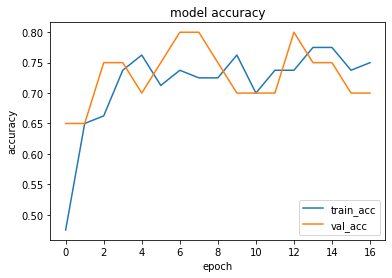

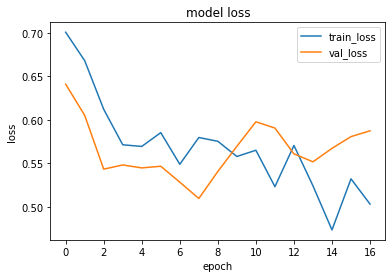

1it [00:00, 17549.39it/s]


prediction for video armflapping_1.mov is [[0.6743312]]


1it [00:00, 14768.68it/s]


prediction for video armflapping_3.mov is [[0.8451736]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_2.mov is [[0.7553979]]


1it [00:00, 14266.34it/s]


prediction for video control_1.mov is [[0.2529049]]


1it [00:00, 16070.13it/s]


prediction for video control_2.mov is [[0.24200314]]


1it [00:00, 14926.35it/s]


prediction for video control_3.mov is [[0.24230027]]
Epoch 1/75
3/3 [==============================] - 1s 299ms/step - loss: 0.6925 - accuracy: 0.4625 - precision_101: 0.4746 - recall_101: 0.7000 - val_loss: 0.6256 - val_accuracy: 0.8000 - val_precision_101: 0.8750 - val_recall_101: 0.7000
Epoch 2/75
3/3 [==============================] - 1s 298ms/step - loss: 0.6753 - accuracy: 0.6625 - precision_101: 0.7097 - recall_101: 0.5500 - val_loss: 0.5812 - val_accuracy: 0.7500 - val_precision_101: 0.7273 - val_recall_101: 0.8000
Epoch 3/75
3/3 [==============================] - 1s 306ms/step - loss: 0.6277 - accuracy: 0.7125 - precision_101: 0.6667 - recall_101: 0.8500 - val_loss: 0.5697 - val_accuracy: 0.7500 - val_precision_101: 0.7778 - val_recall_101: 0.7000
Epoch 4/75
3/3 [==============================] - 1s 348ms/step - loss: 0.5935 - accuracy: 0.6625 - precision_101: 0.6444 - recall_101: 0.7250 - val_loss: 0.6543 - val_accuracy: 0.6500 - val_precision_101: 1.0000 - val_recall_101: 0.

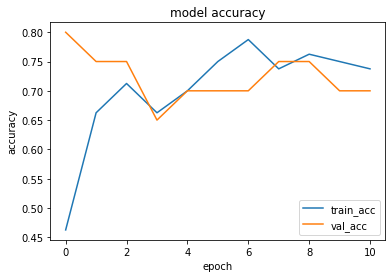

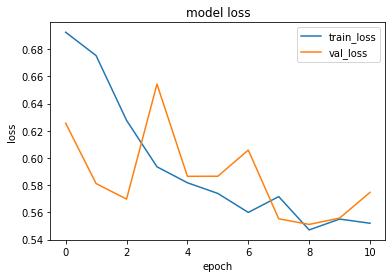

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.5571345]]


1it [00:00, 15420.24it/s]


prediction for video armflapping_3.mov is [[0.5508791]]


1it [00:00, 14563.56it/s]


prediction for video armflapping_2.mov is [[0.6906569]]


1it [00:00, 14716.86it/s]


prediction for video control_1.mov is [[0.22541684]]


1it [00:00, 17623.13it/s]


prediction for video control_2.mov is [[0.18687877]]


1it [00:00, 16710.37it/s]


prediction for video control_3.mov is [[0.1721873]]


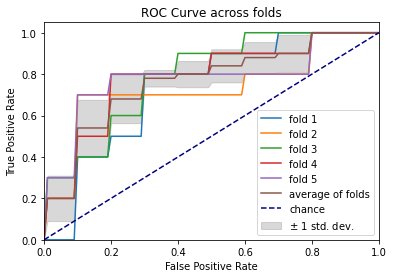

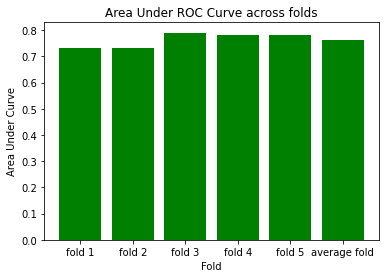

In [185]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 1s 301ms/step - loss: 0.7864 - accuracy: 0.4875 - precision_103: 0.4923 - recall_103: 0.8000 - val_loss: 0.6937 - val_accuracy: 0.6000 - val_precision_103: 0.5833 - val_recall_103: 0.7000
Epoch 2/75
3/3 [==============================] - 1s 290ms/step - loss: 0.6711 - accuracy: 0.6625 - precision_103: 0.8824 - recall_103: 0.3750 - val_loss: 0.6762 - val_accuracy: 0.6000 - val_precision_103: 0.6000 - val_recall_103: 0.6000
Epoch 3/75
3/3 [==============================] - 1s 353ms/step - loss: 0.6473 - accuracy: 0.6625 - precision_103: 0.7407 - recall_103: 0.5000 - val_loss: 0.6998 - val_accuracy: 0.6500 - val_precision_103: 0.6000 - val_recall_103: 0.9000
Epoch 4/75
3/3 [==============================] - 1s 293ms/step - loss: 0.6116 - accuracy: 0.7375 - precision_103: 0.7111 - recall_103: 0.8000 - val_loss: 0.7401 - val_accuracy: 0.6000 - val_precision_103: 0.5625 - val_recall_103: 0.9000
Epoch 5/75
3/3 [==============================] 

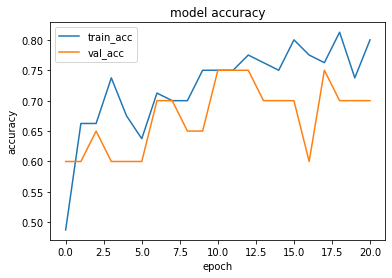

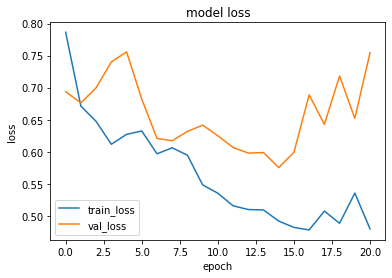

1it [00:00, 13888.42it/s]


prediction for video armflapping_1.mov is [[0.5101842]]


1it [00:00, 13706.88it/s]


prediction for video armflapping_3.mov is [[0.5944793]]


1it [00:00, 13530.01it/s]


prediction for video armflapping_2.mov is [[0.6427985]]


1it [00:00, 15141.89it/s]


prediction for video control_1.mov is [[0.3759649]]


1it [00:00, 14513.16it/s]


prediction for video control_2.mov is [[0.3127057]]


1it [00:00, 14926.35it/s]


prediction for video control_3.mov is [[0.29687843]]
Epoch 1/75
3/3 [==============================] - 1s 393ms/step - loss: 0.7126 - accuracy: 0.4750 - precision_104: 0.4808 - recall_104: 0.6250 - val_loss: 0.6822 - val_accuracy: 0.6500 - val_precision_104: 0.8000 - val_recall_104: 0.4000
Epoch 2/75
3/3 [==============================] - 1s 398ms/step - loss: 0.6593 - accuracy: 0.6500 - precision_104: 0.6579 - recall_104: 0.6250 - val_loss: 0.6040 - val_accuracy: 0.7000 - val_precision_104: 0.6667 - val_recall_104: 0.8000
Epoch 3/75
3/3 [==============================] - 1s 440ms/step - loss: 0.6365 - accuracy: 0.7125 - precision_104: 0.6977 - recall_104: 0.7500 - val_loss: 0.5631 - val_accuracy: 0.7000 - val_precision_104: 0.7000 - val_recall_104: 0.7000
Epoch 4/75
3/3 [==============================] - 1s 395ms/step - loss: 0.5807 - accuracy: 0.7250 - precision_104: 0.6875 - recall_104: 0.8250 - val_loss: 0.5031 - val_accuracy: 0.7500 - val_precision_104: 0.7778 - val_recall_104: 0.

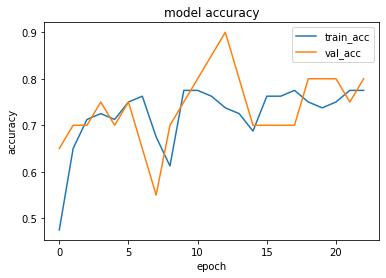

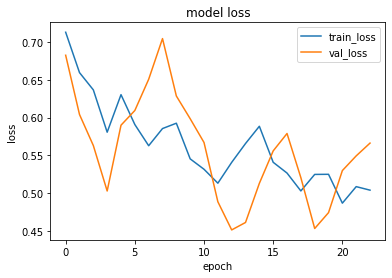

1it [00:00, 16320.25it/s]


prediction for video armflapping_1.mov is [[0.34297657]]


1it [00:00, 12336.19it/s]


prediction for video armflapping_3.mov is [[0.5259273]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_2.mov is [[0.5970534]]


1it [00:00, 14513.16it/s]


prediction for video control_1.mov is [[0.2221295]]


1it [00:00, 16448.25it/s]


prediction for video control_2.mov is [[0.20145902]]


1it [00:00, 16384.00it/s]


prediction for video control_3.mov is [[0.1979652]]
Epoch 1/75
3/3 [==============================] - 1s 381ms/step - loss: 0.7553 - accuracy: 0.5125 - precision_105: 0.5085 - recall_105: 0.7500 - val_loss: 0.6749 - val_accuracy: 0.5500 - val_precision_105: 0.5333 - val_recall_105: 0.8000
Epoch 2/75
3/3 [==============================] - 1s 372ms/step - loss: 0.6684 - accuracy: 0.6500 - precision_105: 0.7308 - recall_105: 0.4750 - val_loss: 0.7087 - val_accuracy: 0.6000 - val_precision_105: 1.0000 - val_recall_105: 0.2000
Epoch 3/75
3/3 [==============================] - 1s 370ms/step - loss: 0.6665 - accuracy: 0.6375 - precision_105: 0.6571 - recall_105: 0.5750 - val_loss: 0.6971 - val_accuracy: 0.6500 - val_precision_105: 0.6154 - val_recall_105: 0.8000
Epoch 4/75
3/3 [==============================] - 1s 416ms/step - loss: 0.6180 - accuracy: 0.6625 - precision_105: 0.6140 - recall_105: 0.8750 - val_loss: 0.6981 - val_accuracy: 0.6500 - val_precision_105: 0.6154 - val_recall_105: 0.8

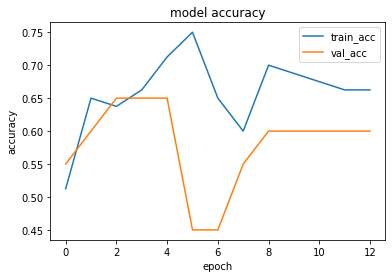

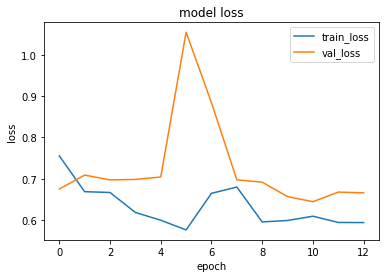

1it [00:00, 12157.40it/s]


prediction for video armflapping_1.mov is [[0.46097893]]


1it [00:00, 13662.23it/s]


prediction for video armflapping_3.mov is [[0.6311012]]


1it [00:00, 13888.42it/s]


prediction for video armflapping_2.mov is [[0.50079846]]


1it [00:00, 14926.35it/s]


prediction for video control_1.mov is [[0.44594455]]


1it [00:00, 13662.23it/s]


prediction for video control_2.mov is [[0.44107693]]


1it [00:00, 11915.64it/s]


prediction for video control_3.mov is [[0.44058433]]
Epoch 1/75
3/3 [==============================] - 1s 481ms/step - loss: 0.7148 - accuracy: 0.5875 - precision_106: 0.5854 - recall_106: 0.6000 - val_loss: 0.6384 - val_accuracy: 0.7000 - val_precision_106: 0.6667 - val_recall_106: 0.8000
Epoch 2/75
3/3 [==============================] - 1s 362ms/step - loss: 0.6466 - accuracy: 0.6875 - precision_106: 0.6667 - recall_106: 0.7500 - val_loss: 0.5897 - val_accuracy: 0.7500 - val_precision_106: 0.7273 - val_recall_106: 0.8000
Epoch 3/75
3/3 [==============================] - 1s 369ms/step - loss: 0.6269 - accuracy: 0.7125 - precision_106: 0.7429 - recall_106: 0.6500 - val_loss: 0.5673 - val_accuracy: 0.8000 - val_precision_106: 0.8000 - val_recall_106: 0.8000
Epoch 4/75
3/3 [==============================] - 1s 359ms/step - loss: 0.5729 - accuracy: 0.7250 - precision_106: 0.7500 - recall_106: 0.6750 - val_loss: 0.5482 - val_accuracy: 0.7500 - val_precision_106: 0.7273 - val_recall_106: 0.

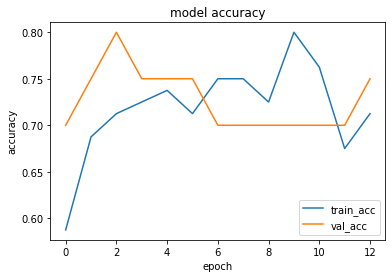

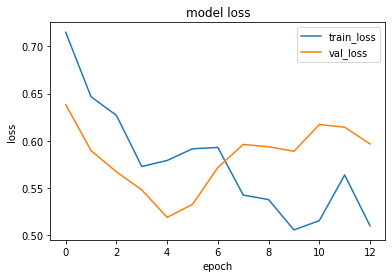

1it [00:00, 15363.75it/s]


prediction for video armflapping_1.mov is [[0.3674506]]


1it [00:00, 16194.22it/s]


prediction for video armflapping_3.mov is [[0.4852226]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_2.mov is [[0.6080451]]


1it [00:00, 13357.66it/s]


prediction for video control_1.mov is [[0.26292008]]


1it [00:00, 13148.29it/s]


prediction for video control_2.mov is [[0.24561328]]


1it [00:00, 15650.39it/s]


prediction for video control_3.mov is [[0.24145028]]
Epoch 1/75
3/3 [==============================] - 1s 421ms/step - loss: 0.6679 - accuracy: 0.6250 - precision_107: 0.5893 - recall_107: 0.8250 - val_loss: 0.5946 - val_accuracy: 0.7000 - val_precision_107: 0.7000 - val_recall_107: 0.7000
Epoch 2/75
3/3 [==============================] - 1s 359ms/step - loss: 0.6492 - accuracy: 0.6625 - precision_107: 0.6970 - recall_107: 0.5750 - val_loss: 0.5772 - val_accuracy: 0.7000 - val_precision_107: 0.7000 - val_recall_107: 0.7000
Epoch 3/75
3/3 [==============================] - 1s 324ms/step - loss: 0.6185 - accuracy: 0.6750 - precision_107: 0.6750 - recall_107: 0.6750 - val_loss: 0.6097 - val_accuracy: 0.6500 - val_precision_107: 0.6364 - val_recall_107: 0.7000
Epoch 4/75
3/3 [==============================] - 1s 407ms/step - loss: 0.6112 - accuracy: 0.7125 - precision_107: 0.6809 - recall_107: 0.8000 - val_loss: 0.6567 - val_accuracy: 0.6500 - val_precision_107: 0.6667 - val_recall_107: 0.

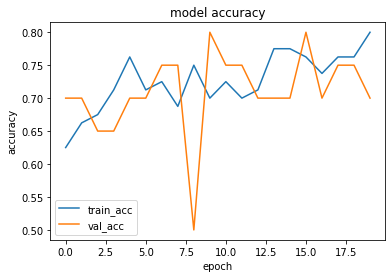

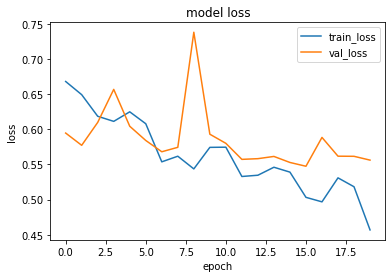

1it [00:00, 12228.29it/s]


prediction for video armflapping_1.mov is [[0.41311914]]


1it [00:00, 13530.01it/s]


prediction for video armflapping_3.mov is [[0.67384493]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_2.mov is [[0.77748406]]


1it [00:00, 15363.75it/s]


prediction for video control_1.mov is [[0.2084718]]


1it [00:00, 12483.05it/s]


prediction for video control_2.mov is [[0.19255996]]


1it [00:00, 14926.35it/s]


prediction for video control_3.mov is [[0.19176793]]


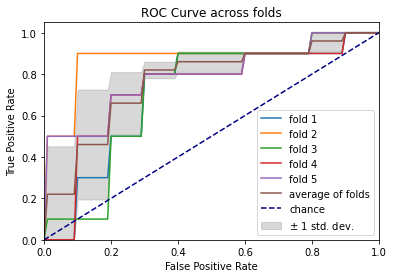

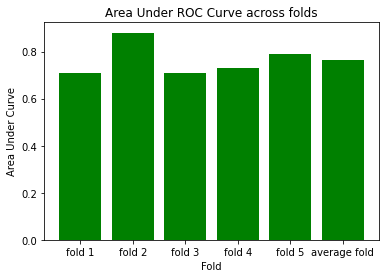

In [186]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 1s 383ms/step - loss: 0.7054 - accuracy: 0.4625 - precision_109: 0.3846 - recall_109: 0.1250 - val_loss: 0.6993 - val_accuracy: 0.6000 - val_precision_109: 0.5625 - val_recall_109: 0.9000
Epoch 2/75
3/3 [==============================] - 1s 380ms/step - loss: 0.6570 - accuracy: 0.6250 - precision_109: 0.5781 - recall_109: 0.9250 - val_loss: 0.7169 - val_accuracy: 0.6000 - val_precision_109: 0.5625 - val_recall_109: 0.9000
Epoch 3/75
3/3 [==============================] - 1s 381ms/step - loss: 0.6348 - accuracy: 0.7250 - precision_109: 0.7045 - recall_109: 0.7750 - val_loss: 0.6685 - val_accuracy: 0.6500 - val_precision_109: 0.6364 - val_recall_109: 0.7000
Epoch 4/75
3/3 [==============================] - 1s 437ms/step - loss: 0.5962 - accuracy: 0.7375 - precision_109: 0.7714 - recall_109: 0.6750 - val_loss: 0.6415 - val_accuracy: 0.6500 - val_precision_109: 0.6364 - val_recall_109: 0.7000
Epoch 5/75
3/3 [==============================] 

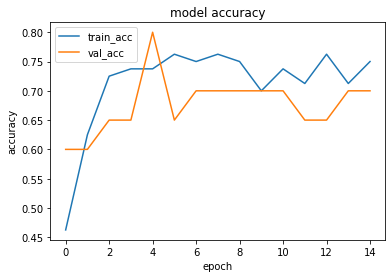

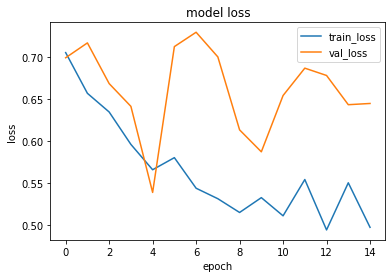

1it [00:00, 15363.75it/s]


prediction for video armflapping_1.mov is [[0.1365934]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_3.mov is [[0.5979474]]


1it [00:00, 15592.21it/s]


prediction for video armflapping_2.mov is [[0.6291888]]


1it [00:00, 17549.39it/s]


prediction for video control_1.mov is [[0.0959608]]


1it [00:00, 14979.66it/s]


prediction for video control_2.mov is [[0.09253603]]


1it [00:00, 15650.39it/s]


prediction for video control_3.mov is [[0.09626395]]
Epoch 1/75
3/3 [==============================] - 1s 385ms/step - loss: 0.7176 - accuracy: 0.4625 - precision_110: 0.4727 - recall_110: 0.6500 - val_loss: 0.6484 - val_accuracy: 0.7000 - val_precision_110: 0.8333 - val_recall_110: 0.5000
Epoch 2/75
3/3 [==============================] - 1s 415ms/step - loss: 0.6462 - accuracy: 0.7500 - precision_110: 0.7273 - recall_110: 0.8000 - val_loss: 0.6308 - val_accuracy: 0.6000 - val_precision_110: 0.5833 - val_recall_110: 0.7000
Epoch 3/75
3/3 [==============================] - 1s 390ms/step - loss: 0.6234 - accuracy: 0.6250 - precision_110: 0.5758 - recall_110: 0.9500 - val_loss: 0.8315 - val_accuracy: 0.7500 - val_precision_110: 1.0000 - val_recall_110: 0.5000
Epoch 4/75
3/3 [==============================] - 1s 343ms/step - loss: 0.9469 - accuracy: 0.5875 - precision_110: 0.7692 - recall_110: 0.2500 - val_loss: 0.8285 - val_accuracy: 0.5000 - val_precision_110: 0.0000e+00 - val_recall_110

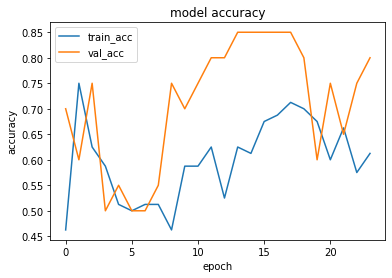

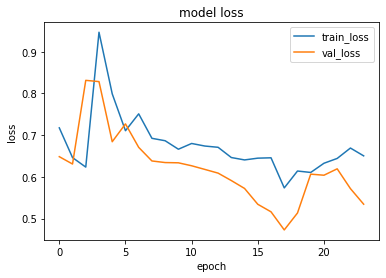

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.49944293]]


1it [00:00, 12710.01it/s]


prediction for video armflapping_3.mov is [[0.4986533]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_2.mov is [[0.52340835]]


1it [00:00, 14926.35it/s]


prediction for video control_1.mov is [[0.49102747]]


1it [00:00, 16980.99it/s]


prediction for video control_2.mov is [[0.48753855]]


1it [00:00, 14768.68it/s]


prediction for video control_3.mov is [[0.4874633]]
Epoch 1/75
3/3 [==============================] - 1s 323ms/step - loss: 0.7019 - accuracy: 0.4625 - precision_111: 0.4444 - recall_111: 0.3000 - val_loss: 0.7187 - val_accuracy: 0.5000 - val_precision_111: 0.5000 - val_recall_111: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 316ms/step - loss: 0.6237 - accuracy: 0.6000 - precision_111: 0.5588 - recall_111: 0.9500 - val_loss: 0.6971 - val_accuracy: 0.7000 - val_precision_111: 0.7500 - val_recall_111: 0.6000
Epoch 3/75
3/3 [==============================] - 1s 314ms/step - loss: 0.6468 - accuracy: 0.6375 - precision_111: 0.7895 - recall_111: 0.3750 - val_loss: 0.7128 - val_accuracy: 0.6000 - val_precision_111: 0.7500 - val_recall_111: 0.3000
Epoch 4/75
3/3 [==============================] - 1s 422ms/step - loss: 0.6052 - accuracy: 0.7000 - precision_111: 0.7667 - recall_111: 0.5750 - val_loss: 0.6880 - val_accuracy: 0.7000 - val_precision_111: 0.7500 - val_recall_111: 0.6

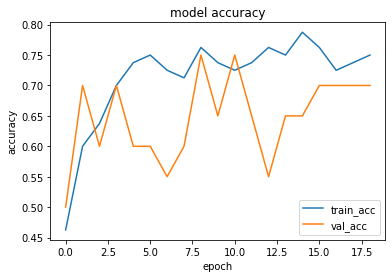

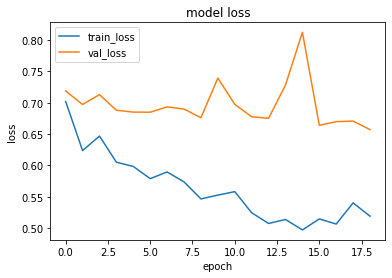

1it [00:00, 15420.24it/s]


prediction for video armflapping_1.mov is [[0.5148168]]


1it [00:00, 12787.51it/s]


prediction for video armflapping_3.mov is [[0.37696984]]


1it [00:00, 14979.66it/s]


prediction for video armflapping_2.mov is [[0.60582364]]


1it [00:00, 14463.12it/s]


prediction for video control_1.mov is [[0.40615138]]


1it [00:00, 14665.40it/s]


prediction for video control_2.mov is [[0.30717975]]


1it [00:00, 15650.39it/s]


prediction for video control_3.mov is [[0.32338303]]
Epoch 1/75
3/3 [==============================] - 1s 305ms/step - loss: 0.7376 - accuracy: 0.3750 - precision_112: 0.3864 - recall_112: 0.4250 - val_loss: 0.6573 - val_accuracy: 0.6000 - val_precision_112: 0.5556 - val_recall_112: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 299ms/step - loss: 0.6637 - accuracy: 0.6000 - precision_112: 0.5625 - recall_112: 0.9000 - val_loss: 0.6321 - val_accuracy: 0.7500 - val_precision_112: 0.7273 - val_recall_112: 0.8000
Epoch 3/75
3/3 [==============================] - 1s 294ms/step - loss: 0.6268 - accuracy: 0.7375 - precision_112: 0.7209 - recall_112: 0.7750 - val_loss: 0.5725 - val_accuracy: 0.7500 - val_precision_112: 0.6923 - val_recall_112: 0.9000
Epoch 4/75
3/3 [==============================] - 1s 388ms/step - loss: 0.6171 - accuracy: 0.7000 - precision_112: 0.6739 - recall_112: 0.7750 - val_loss: 0.5485 - val_accuracy: 0.7500 - val_precision_112: 0.7273 - val_recall_112: 0.

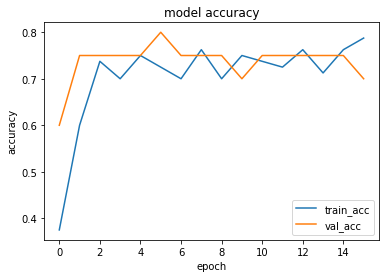

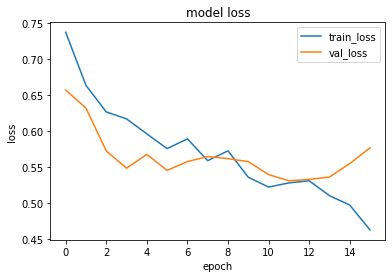

1it [00:00, 15363.75it/s]


prediction for video armflapping_1.mov is [[0.48345214]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_3.mov is [[0.3567807]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_2.mov is [[0.7715484]]


1it [00:00, 13888.42it/s]


prediction for video control_1.mov is [[0.30214202]]


1it [00:00, 14873.42it/s]


prediction for video control_2.mov is [[0.26063448]]


1it [00:00, 15141.89it/s]


prediction for video control_3.mov is [[0.26082474]]
Epoch 1/75
3/3 [==============================] - 1s 326ms/step - loss: 0.7900 - accuracy: 0.3375 - precision_113: 0.3968 - recall_113: 0.6250 - val_loss: 0.6747 - val_accuracy: 0.7000 - val_precision_113: 0.7500 - val_recall_113: 0.6000
Epoch 2/75
3/3 [==============================] - 1s 307ms/step - loss: 0.6916 - accuracy: 0.5750 - precision_113: 0.5882 - recall_113: 0.5000 - val_loss: 0.6710 - val_accuracy: 0.5000 - val_precision_113: 0.0000e+00 - val_recall_113: 0.0000e+00
Epoch 3/75
3/3 [==============================] - 1s 294ms/step - loss: 0.6527 - accuracy: 0.6750 - precision_113: 0.7917 - recall_113: 0.4750 - val_loss: 0.6418 - val_accuracy: 0.7000 - val_precision_113: 1.0000 - val_recall_113: 0.4000
Epoch 4/75
3/3 [==============================] - 1s 299ms/step - loss: 0.6400 - accuracy: 0.6625 - precision_113: 0.6383 - recall_113: 0.7500 - val_loss: 0.5958 - val_accuracy: 0.7000 - val_precision_113: 0.7000 - val_recall

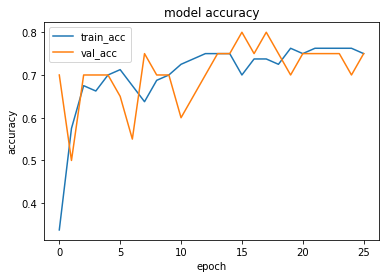

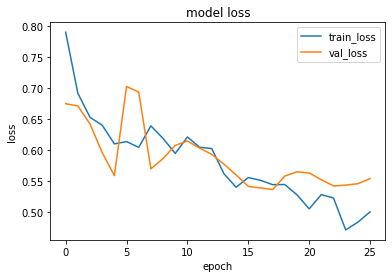

1it [00:00, 14122.24it/s]


prediction for video armflapping_1.mov is [[0.48017833]]


1it [00:00, 13357.66it/s]


prediction for video armflapping_3.mov is [[0.67490953]]


1it [00:00, 14122.24it/s]


prediction for video armflapping_2.mov is [[0.74756193]]


1it [00:00, 14873.42it/s]


prediction for video control_1.mov is [[0.26799595]]


1it [00:00, 14463.12it/s]


prediction for video control_2.mov is [[0.23137176]]


1it [00:00, 15887.52it/s]


prediction for video control_3.mov is [[0.23197648]]


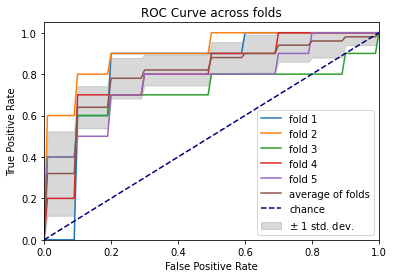

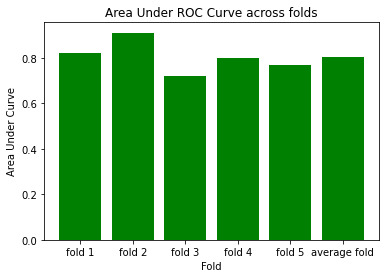

In [187]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 1s 416ms/step - loss: 0.7163 - accuracy: 0.5875 - precision_115: 0.5745 - recall_115: 0.6750 - val_loss: 0.6910 - val_accuracy: 0.6500 - val_precision_115: 0.6000 - val_recall_115: 0.9000
Epoch 2/75
3/3 [==============================] - 1s 315ms/step - loss: 0.6385 - accuracy: 0.7250 - precision_115: 0.7250 - recall_115: 0.7250 - val_loss: 0.6564 - val_accuracy: 0.7000 - val_precision_115: 0.6429 - val_recall_115: 0.9000
Epoch 3/75
3/3 [==============================] - 1s 323ms/step - loss: 0.5916 - accuracy: 0.7000 - precision_115: 0.7222 - recall_115: 0.6500 - val_loss: 0.6549 - val_accuracy: 0.6500 - val_precision_115: 0.6000 - val_recall_115: 0.9000
Epoch 4/75
3/3 [==============================] - 1s 336ms/step - loss: 0.6916 - accuracy: 0.6500 - precision_115: 0.5968 - recall_115: 0.9250 - val_loss: 0.6776 - val_accuracy: 0.7000 - val_precision_115: 0.6429 - val_recall_115: 0.9000
Epoch 5/75
3/3 [==============================] 

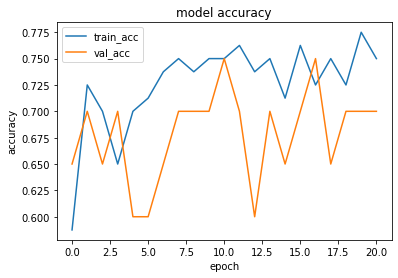

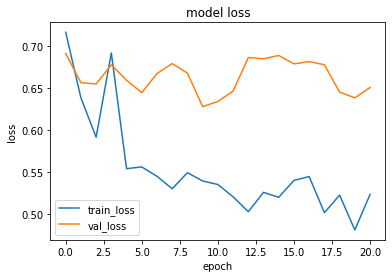

1it [00:00, 14873.42it/s]


prediction for video armflapping_1.mov is [[0.52127475]]


1it [00:00, 14315.03it/s]


prediction for video armflapping_3.mov is [[0.5525492]]


1it [00:00, 12018.06it/s]


prediction for video armflapping_2.mov is [[0.6533759]]


1it [00:00, 15592.21it/s]


prediction for video control_1.mov is [[0.4055604]]


1it [00:00, 13888.42it/s]


prediction for video control_2.mov is [[0.28829584]]


1it [00:00, 16320.25it/s]


prediction for video control_3.mov is [[0.33264694]]
Epoch 1/75
3/3 [==============================] - 1s 384ms/step - loss: 0.7089 - accuracy: 0.4250 - precision_116: 0.4464 - recall_116: 0.6250 - val_loss: 0.6967 - val_accuracy: 0.3000 - val_precision_116: 0.3333 - val_recall_116: 0.4000
Epoch 2/75
3/3 [==============================] - 1s 388ms/step - loss: 0.6600 - accuracy: 0.5125 - precision_116: 0.5077 - recall_116: 0.8250 - val_loss: 0.6015 - val_accuracy: 0.7000 - val_precision_116: 0.6667 - val_recall_116: 0.8000
Epoch 3/75
3/3 [==============================] - 1s 391ms/step - loss: 0.6126 - accuracy: 0.7125 - precision_116: 0.6889 - recall_116: 0.7750 - val_loss: 0.6164 - val_accuracy: 0.6500 - val_precision_116: 0.6364 - val_recall_116: 0.7000
Epoch 4/75
3/3 [==============================] - 1s 399ms/step - loss: 0.5666 - accuracy: 0.7500 - precision_116: 0.7381 - recall_116: 0.7750 - val_loss: 0.5535 - val_accuracy: 0.8000 - val_precision_116: 0.8750 - val_recall_116: 0.

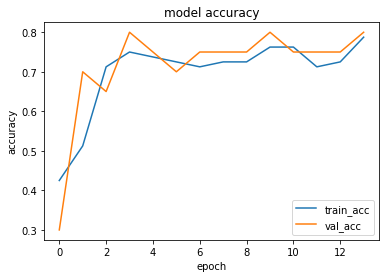

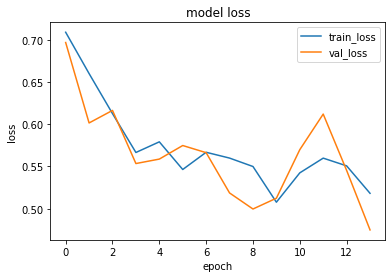

1it [00:00, 12052.60it/s]


prediction for video armflapping_1.mov is [[0.3853602]]


1it [00:00, 13400.33it/s]


prediction for video armflapping_3.mov is [[0.4429206]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_2.mov is [[0.579175]]


1it [00:00, 12985.46it/s]


prediction for video control_1.mov is [[0.3753952]]


1it [00:00, 13148.29it/s]


prediction for video control_2.mov is [[0.3136607]]


1it [00:00, 14513.16it/s]


prediction for video control_3.mov is [[0.334499]]
Epoch 1/75
3/3 [==============================] - 1s 400ms/step - loss: 0.7014 - accuracy: 0.4375 - precision_117: 0.4590 - recall_117: 0.7000 - val_loss: 0.6866 - val_accuracy: 0.7000 - val_precision_117: 0.8333 - val_recall_117: 0.5000
Epoch 2/75
3/3 [==============================] - 1s 389ms/step - loss: 0.6532 - accuracy: 0.6750 - precision_117: 0.7059 - recall_117: 0.6000 - val_loss: 0.6702 - val_accuracy: 0.6500 - val_precision_117: 0.6667 - val_recall_117: 0.6000
Epoch 3/75
3/3 [==============================] - 1s 384ms/step - loss: 0.5986 - accuracy: 0.7375 - precision_117: 0.7021 - recall_117: 0.8250 - val_loss: 0.6585 - val_accuracy: 0.7500 - val_precision_117: 0.7273 - val_recall_117: 0.8000
Epoch 4/75
3/3 [==============================] - 1s 423ms/step - loss: 0.5653 - accuracy: 0.7250 - precision_117: 0.6875 - recall_117: 0.8250 - val_loss: 0.7045 - val_accuracy: 0.6500 - val_precision_117: 0.6154 - val_recall_117: 0.80

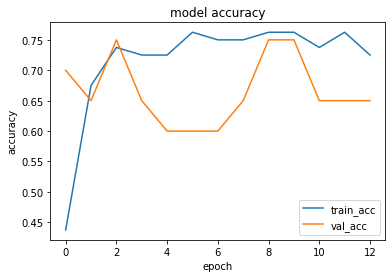

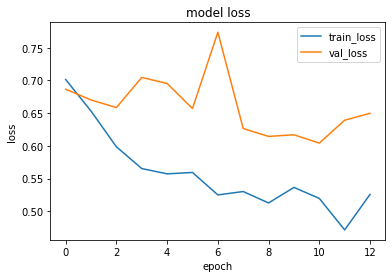

1it [00:00, 13486.51it/s]


prediction for video armflapping_1.mov is [[0.28026477]]


1it [00:00, 11650.84it/s]


prediction for video armflapping_3.mov is [[0.43573886]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_2.mov is [[0.61132437]]


1it [00:00, 14513.16it/s]


prediction for video control_1.mov is [[0.21648586]]


1it [00:00, 15592.21it/s]


prediction for video control_2.mov is [[0.19326767]]


1it [00:00, 14768.68it/s]


prediction for video control_3.mov is [[0.19348589]]
Epoch 1/75
3/3 [==============================] - 1s 370ms/step - loss: 0.6883 - accuracy: 0.4125 - precision_118: 0.4222 - recall_118: 0.4750 - val_loss: 0.7868 - val_accuracy: 0.5000 - val_precision_118: 0.5000 - val_recall_118: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 381ms/step - loss: 0.7076 - accuracy: 0.5875 - precision_118: 0.5538 - recall_118: 0.9000 - val_loss: 0.6621 - val_accuracy: 0.6500 - val_precision_118: 0.6154 - val_recall_118: 0.8000
Epoch 3/75
3/3 [==============================] - 1s 374ms/step - loss: 0.6472 - accuracy: 0.6875 - precision_118: 0.6829 - recall_118: 0.7000 - val_loss: 0.6108 - val_accuracy: 0.7000 - val_precision_118: 0.6667 - val_recall_118: 0.8000
Epoch 4/75
3/3 [==============================] - 1s 367ms/step - loss: 0.5907 - accuracy: 0.7000 - precision_118: 0.6905 - recall_118: 0.7250 - val_loss: 0.5707 - val_accuracy: 0.7500 - val_precision_118: 0.7273 - val_recall_118: 0.

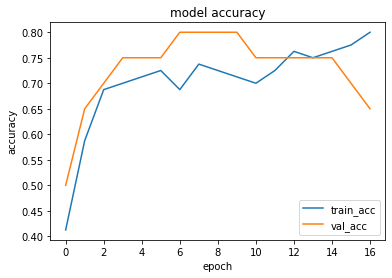

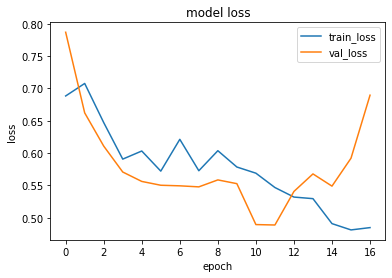

1it [00:00, 15363.75it/s]


prediction for video armflapping_1.mov is [[0.42037317]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_3.mov is [[0.541206]]


1it [00:00, 15592.21it/s]


prediction for video armflapping_2.mov is [[0.5512985]]


1it [00:00, 15420.24it/s]


prediction for video control_1.mov is [[0.22580364]]


1it [00:00, 12372.58it/s]


prediction for video control_2.mov is [[0.18435964]]


1it [00:00, 14315.03it/s]


prediction for video control_3.mov is [[0.17364645]]
Epoch 1/75
3/3 [==============================] - 1s 329ms/step - loss: 0.6882 - accuracy: 0.4875 - precision_119: 0.4872 - recall_119: 0.4750 - val_loss: 0.7140 - val_accuracy: 0.5000 - val_precision_119: 0.5000 - val_recall_119: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 319ms/step - loss: 0.7126 - accuracy: 0.6000 - precision_119: 0.5606 - recall_119: 0.9250 - val_loss: 0.6489 - val_accuracy: 0.6000 - val_precision_119: 0.6667 - val_recall_119: 0.4000
Epoch 3/75
3/3 [==============================] - 1s 318ms/step - loss: 0.6356 - accuracy: 0.7250 - precision_119: 0.7812 - recall_119: 0.6250 - val_loss: 0.6013 - val_accuracy: 0.7000 - val_precision_119: 0.7500 - val_recall_119: 0.6000
Epoch 4/75
3/3 [==============================] - 1s 430ms/step - loss: 0.5633 - accuracy: 0.7625 - precision_119: 0.7838 - recall_119: 0.7250 - val_loss: 0.6096 - val_accuracy: 0.7000 - val_precision_119: 0.7000 - val_recall_119: 0.

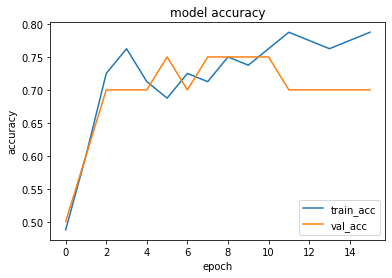

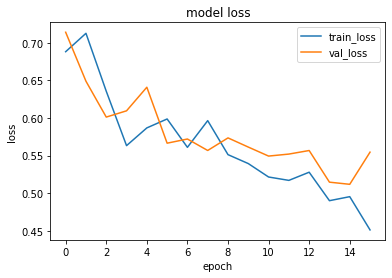

1it [00:00, 13662.23it/s]


prediction for video armflapping_1.mov is [[0.65980744]]


1it [00:00, 19239.93it/s]


prediction for video armflapping_3.mov is [[0.7900686]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_2.mov is [[0.8336911]]


1it [00:00, 13662.23it/s]


prediction for video control_1.mov is [[0.25740308]]


1it [00:00, 13357.66it/s]


prediction for video control_2.mov is [[0.23153213]]


1it [00:00, 14979.66it/s]


prediction for video control_3.mov is [[0.22699809]]


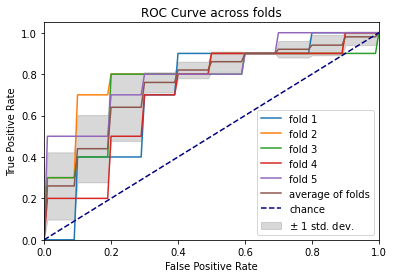

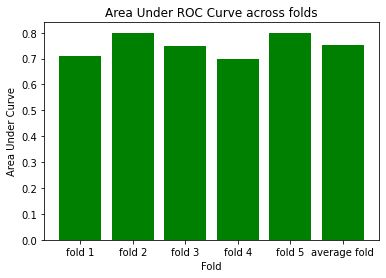

In [188]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

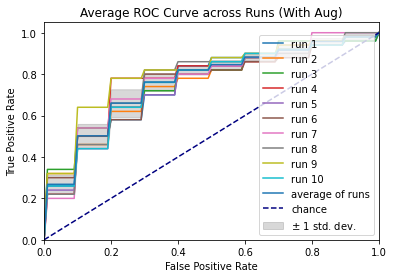

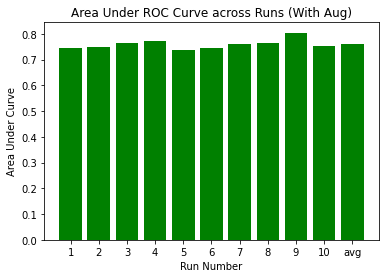

In [189]:
# REEE RUN THIS STUFF 
plot_meta_roc_auroc(AVERAGE_AUROCS, AVERAGE_TPRS, np.linspace(0, 1, 101)) # save the images here 

In [190]:
np.mean(AVERAGE_AUROCS), np.std(AVERAGE_AUROCS)

(0.7594000000000001, 0.016928727600792032)

In [191]:
def interpret(metrics_string):
     metrics = []
     for i in range(len(metrics_string)):
         try:
             index = metrics_string.index(":")
             metrics.append(metrics_string[index + 2 : index + 8])
             metrics_string = metrics_string[index + 9:]
         except Exception as e:
             return [float(m) for m in metrics][1:]

In [200]:
METRICS = [] # training acc, training pres, training recall, validation acc, validation pres, validation recall 

# for all of the 50 runs have a (50, 6 + 2) matrix, and then use that to store data and compute scores 

meta_results = []
meta_results.append("3/3 [==============================] - 1s 347ms/step - loss: 0.5398 - accuracy: 0.7500 - precision_61: 0.7778 - recall_61: 0.7000 - val_loss: 0.6666 - val_accuracy: 0.7000 - val_precision_61: 0.6429 - val_recall_61: 0.9000")
meta_results.append("3/3 [==============================] - 1s 293ms/step - loss: 0.4832 - accuracy: 0.8000 - precision_62: 0.7609 - recall_62: 0.8750 - val_loss: 0.5889 - val_accuracy: 0.7500 - val_precision_62: 0.7778 - val_recall_62: 0.7000")
meta_results.append("3/3 [==============================] - 1s 352ms/step - loss: 0.5292 - accuracy: 0.7625 - precision_63: 0.7561 - recall_63: 0.7750 - val_loss: 0.6466 - val_accuracy: 0.6500 - val_precision_63: 0.7143 - val_recall_63: 0.5000")
meta_results.append("3/3 [==============================] - 1s 301ms/step - loss: 0.5226 - accuracy: 0.7375 - precision_64: 0.8800 - recall_64: 0.5500 - val_loss: 0.5404 - val_accuracy: 0.7500 - val_precision_64: 0.7778 - val_recall_64: 0.7000")
meta_results.append("3/3 [==============================] - 1s 309ms/step - loss: 0.5921 - accuracy: 0.7250 - precision_65: 0.7250 - recall_65: 0.7250 - val_loss: 0.5698 - val_accuracy: 0.7000 - val_precision_65: 0.7000 - val_recall_65: 0.7000")
meta_results.append("3/3 [==============================] - 1s 305ms/step - loss: 0.3841 - accuracy: 0.8000 - precision_67: 0.8529 - recall_67: 0.7250 - val_loss: 0.7922 - val_accuracy: 0.7000 - val_precision_67: 0.7000 - val_recall_67: 0.7000")
meta_results.append("3/3 [==============================] - 1s 352ms/step - loss: 0.4856 - accuracy: 0.7750 - precision_68: 0.7895 - recall_68: 0.7500 - val_loss: 0.7474 - val_accuracy: 0.6000 - val_precision_68: 0.7500 - val_recall_68: 0.3000")
meta_results.append("3/3 [==============================] - 1s 322ms/step - loss: 0.4714 - accuracy: 0.7625 - precision_69: 0.7442 - recall_69: 0.8000 - val_loss: 0.6697 - val_accuracy: 0.7500 - val_precision_69: 0.7778 - val_recall_69: 0.7000")
meta_results.append('3/3 [==============================] - 1s 296ms/step - loss: 0.4690 - accuracy: 0.7750 - precision_70: 0.8235 - recall_70: 0.7000 - val_loss: 0.6353 - val_accuracy: 0.7000 - val_precision_70: 0.6667 - val_recall_70: 0.8000')
meta_results.append("3/3 [==============================] - 1s 290ms/step - loss: 0.4460 - accuracy: 0.8125 - precision_71: 0.8049 - recall_71: 0.8250 - val_loss: 0.5847 - val_accuracy: 0.7500 - val_precision_71: 0.7778 - val_recall_71: 0.7000")
meta_results.append("3/3 [==============================] - 1s 360ms/step - loss: 0.4186 - accuracy: 0.8125 - precision_73: 0.9310 - recall_73: 0.6750 - val_loss: 0.7823 - val_accuracy: 0.6500 - val_precision_73: 0.6154 - val_recall_73: 0.8000")
meta_results.append("3/3 [==============================] - 1s 317ms/step - loss: 0.5261 - accuracy: 0.7750 - precision_74: 0.7750 - recall_74: 0.7750 - val_loss: 0.5484 - val_accuracy: 0.6500 - val_precision_74: 0.6364 - val_recall_74: 0.7000")
meta_results.append("3/3 [==============================] - 1s 292ms/step - loss: 0.4525 - accuracy: 0.8125 - precision_75: 0.8205 - recall_75: 0.8000 - val_loss: 0.6313 - val_accuracy: 0.5500 - val_precision_75: 0.5556 - val_recall_75: 0.5000")
meta_results.append("3/3 [==============================] - 1s 303ms/step - loss: 0.5063 - accuracy: 0.7500 - precision_76: 0.8125 - recall_76: 0.6500 - val_loss: 0.5860 - val_accuracy: 0.7500 - val_precision_76: 0.7273 - val_recall_76: 0.8000")
meta_results.append("3/3 [==============================] - 1s 290ms/step - loss: 0.5438 - accuracy: 0.7250 - precision_77: 0.7250 - recall_77: 0.7250 - val_loss: 0.5869 - val_accuracy: 0.7000 - val_precision_77: 0.7500 - val_recall_77: 0.6000")
meta_results.append("3/3 [==============================] - 1s 302ms/step - loss: 0.5086 - accuracy: 0.7750 - precision_79: 0.8056 - recall_79: 0.7250 - val_loss: 0.6807 - val_accuracy: 0.7500 - val_precision_79: 0.6923 - val_recall_79: 0.9000")
meta_results.append("3/3 [==============================] - 1s 310ms/step - loss: 0.5252 - accuracy: 0.7500 - precision_80: 0.8571 - recall_80: 0.6000 - val_loss: 0.5511 - val_accuracy: 0.8000 - val_precision_80: 0.8750 - val_recall_80: 0.7000")
meta_results.append("3/3 [==============================] - 1s 350ms/step - loss: 0.5248 - accuracy: 0.7875 - precision_81: 0.8108 - recall_81: 0.7500 - val_loss: 0.6378 - val_accuracy: 0.7000 - val_precision_81: 0.7500 - val_recall_81: 0.6000")
meta_results.append("3/3 [==============================] - 1s 357ms/step - loss: 0.4598 - accuracy: 0.8125 - precision_82: 0.8049 - recall_82: 0.8250 - val_loss: 0.5321 - val_accuracy: 0.7500 - val_precision_82: 0.8571 - val_recall_82: 0.6000")
meta_results.append("3/3 [==============================] - 1s 290ms/step - loss: 0.5211 - accuracy: 0.7625 - precision_83: 0.7692 - recall_83: 0.7500 - val_loss: 0.5633 - val_accuracy: 0.7000 - val_precision_83: 0.7500 - val_recall_83: 0.6000")
meta_results.append("3/3 [==============================] - 1s 300ms/step - loss: 0.5551 - accuracy: 0.7250 - precision_85: 0.7647 - recall_85: 0.6500 - val_loss: 0.6165 - val_accuracy: 0.7500 - val_precision_85: 0.6923 - val_recall_85: 0.9000")
meta_results.append("3/3 [==============================] - 1s 315ms/step - loss: 0.5246 - accuracy: 0.7625 - precision_86: 0.7838 - recall_86: 0.7250 - val_loss: 0.6129 - val_accuracy: 0.7500 - val_precision_86: 0.7778 - val_recall_86: 0.7000")
meta_results.append("3/3 [==============================] - 1s 287ms/step - loss: 0.5243 - accuracy: 0.7750 - precision_87: 0.7895 - recall_87: 0.7500 - val_loss: 0.6616 - val_accuracy: 0.7000 - val_precision_87: 0.7500 - val_recall_87: 0.6000")
meta_results.append("3/3 [==============================] - 1s 295ms/step - loss: 0.4972 - accuracy: 0.7875 - precision_88: 0.8108 - recall_88: 0.7500 - val_loss: 0.5623 - val_accuracy: 0.7000 - val_precision_88: 0.7000 - val_recall_88: 0.7000")
meta_results.append("3/3 [==============================] - 1s 301ms/step - loss: 0.5600 - accuracy: 0.7625 - precision_89: 0.7442 - recall_89: 0.8000 - val_loss: 0.6005 - val_accuracy: 0.7500 - val_precision_89: 0.7778 - val_recall_89: 0.7000")
meta_results.append("3/3 [==============================] - 1s 284ms/step - loss: 0.5493 - accuracy: 0.7250 - precision_91: 0.7812 - recall_91: 0.6250 - val_loss: 0.6867 - val_accuracy: 0.6500 - val_precision_91: 0.6667 - val_recall_91: 0.6000")
meta_results.append("3/3 [==============================] - 1s 308ms/step - loss: 0.5538 - accuracy: 0.7500 - precision_92: 0.8125 - recall_92: 0.6500 - val_loss: 0.5545 - val_accuracy: 0.8000 - val_precision_92: 0.8750 - val_recall_92: 0.7000")
meta_results.append("3/3 [==============================] - 1s 304ms/step - loss: 0.5237 - accuracy: 0.7625 - precision_93: 0.7692 - recall_93: 0.7500 - val_loss: 0.6715 - val_accuracy: 0.7000 - val_precision_93: 0.8333 - val_recall_93: 0.5000")
meta_results.append("3/3 [==============================] - 1s 290ms/step - loss: 0.4892 - accuracy: 0.7625 - precision_94: 0.7838 - recall_94: 0.7250 - val_loss: 0.6911 - val_accuracy: 0.7000 - val_precision_94: 0.7000 - val_recall_94: 0.7000")
meta_results.append("3/3 [==============================] - 1s 355ms/step - loss: 0.5069 - accuracy: 0.7750 - precision_95: 0.7391 - recall_95: 0.8500 - val_loss: 0.5830 - val_accuracy: 0.7500 - val_precision_95: 0.7778 - val_recall_95: 0.7000")
meta_results.append("3/3 [==============================] - 1s 301ms/step - loss: 0.4623 - accuracy: 0.7625 - precision_97: 0.8387 - recall_97: 0.6500 - val_loss: 0.6886 - val_accuracy: 0.7000 - val_precision_97: 0.6667 - val_recall_97: 0.8000")
meta_results.append("3/3 [==============================] - 1s 301ms/step - loss: 0.4394 - accuracy: 0.8125 - precision_98: 0.8378 - recall_98: 0.7750 - val_loss: 0.5548 - val_accuracy: 0.7500 - val_precision_98: 0.7778 - val_recall_98: 0.7000")
meta_results.append("3/3 [==============================] - 1s 294ms/step - loss: 0.5807 - accuracy: 0.6500 - precision_99: 0.6429 - recall_99: 0.6750 - val_loss: 0.6015 - val_accuracy: 0.6500 - val_precision_99: 0.7143 - val_recall_99: 0.5000")
meta_results.append("3/3 [==============================] - 1s 297ms/step - loss: 0.5031 - accuracy: 0.7500 - precision_100: 0.7381 - recall_100: 0.7750 - val_loss: 0.5875 - val_accuracy: 0.7000 - val_precision_100: 0.6667 - val_recall_100: 0.8000")
meta_results.append("3/3 [==============================] - 1s 289ms/step - loss: 0.5520 - accuracy: 0.7375 - precision_101: 0.7317 - recall_101: 0.7500 - val_loss: 0.5747 - val_accuracy: 0.7000 - val_precision_101: 0.8333 - val_recall_101: 0.5000")
meta_results.append("3/3 [==============================] - 1s 326ms/step - loss: 0.4796 - accuracy: 0.8000 - precision_103: 0.9000 - recall_103: 0.6750 - val_loss: 0.7545 - val_accuracy: 0.7000 - val_precision_103: 0.7000 - val_recall_103: 0.7000")
meta_results.append("3/3 [==============================] - 1s 362ms/step - loss: 0.5042 - accuracy: 0.7750 - precision_104: 0.7895 - recall_104: 0.7500 - val_loss: 0.5663 - val_accuracy: 0.8000 - val_precision_104: 0.8750 - val_recall_104: 0.7000")
meta_results.append("3/3 [==============================] - 1s 319ms/step - loss: 0.5935 - accuracy: 0.6625 - precision_105: 0.6383 - recall_105: 0.7500 - val_loss: 0.6656 - val_accuracy: 0.6000 - val_precision_105: 0.6250 - val_recall_105: 0.5000")
meta_results.append("3/3 [==============================] - 1s 322ms/step - loss: 0.5102 - accuracy: 0.7125 - precision_106: 0.6889 - recall_106: 0.7750 - val_loss: 0.5967 - val_accuracy: 0.7500 - val_precision_106: 0.7273 - val_recall_106: 0.8000")
meta_results.append("3/3 [==============================] - 1s 292ms/step - loss: 0.4569 - accuracy: 0.8000 - precision_107: 0.8000 - recall_107: 0.8000 - val_loss: 0.5561 - val_accuracy: 0.7000 - val_precision_107: 0.7500 - val_recall_107: 0.6000")
meta_results.append("3/3 [==============================] - 1s 315ms/step - loss: 0.4976 - accuracy: 0.7500 - precision_109: 0.7778 - recall_109: 0.7000 - val_loss: 0.6449 - val_accuracy: 0.7000 - val_precision_109: 0.6429 - val_recall_109: 0.9000")
meta_results.append("3/3 [==============================] - 1s 364ms/step - loss: 0.6504 - accuracy: 0.6125 - precision_110: 0.7647 - recall_110: 0.3250 - val_loss: 0.5344 - val_accuracy: 0.8000 - val_precision_110: 0.8750 - val_recall_110: 0.7000")
meta_results.append("3/3 [==============================] - 1s 359ms/step - loss: 0.5191 - accuracy: 0.7500 - precision_111: 0.7778 - recall_111: 0.7000 - val_loss: 0.6570 - val_accuracy: 0.7000 - val_precision_111: 0.7500 - val_recall_111: 0.600")
meta_results.append("3/3 [==============================] - 1s 310ms/step - loss: 0.4627 - accuracy: 0.7875 - precision_112: 0.8108 - recall_112: 0.7500 - val_loss: 0.5769 - val_accuracy: 0.7000 - val_precision_112: 0.6667 - val_recall_112: 0.8000")
meta_results.append("3/3 [==============================] - 1s 298ms/step - loss: 0.5000 - accuracy: 0.7500 - precision_113: 0.7273 - recall_113: 0.8000 - val_loss: 0.5538 - val_accuracy: 0.7500 - val_precision_113: 0.7778 - val_recall_113: 0.7000")
meta_results.append("3/3 [==============================] - 1s 316ms/step - loss: 0.5236 - accuracy: 0.7500 - precision_115: 0.7500 - recall_115: 0.7500 - val_loss: 0.6507 - val_accuracy: 0.7000 - val_precision_115: 0.6429 - val_recall_115: 0.9000")
meta_results.append("3/3 [==============================] - 1s 367ms/step - loss: 0.5182 - accuracy: 0.7875 - precision_116: 0.7805 - recall_116: 0.8000 - val_loss: 0.4749 - val_accuracy: 0.8000 - val_precision_116: 0.8000 - val_recall_116: 0.8000")
meta_results.append("3/3 [==============================] - 1s 311ms/step - loss: 0.5259 - accuracy: 0.7250 - precision_117: 0.7812 - recall_117: 0.6250 - val_loss: 0.6497 - val_accuracy: 0.6500 - val_precision_117: 1.0000 - val_recall_117: 0.3000")
meta_results.append("3/3 [==============================] - 1s 418ms/step - loss: 0.4848 - accuracy: 0.8000 - precision_118: 0.8158 - recall_118: 0.7750 - val_loss: 0.6895 - val_accuracy: 0.6500 - val_precision_118: 0.6364 - val_recall_118: 0.7000")
meta_results.append("3/3 [==============================] - 1s 359ms/step - loss: 0.4513 - accuracy: 0.7875 - precision_119: 0.7805 - recall_119: 0.8000 - val_loss: 0.5546 - val_accuracy: 0.7000 - val_precision_119: 0.7500 - val_recall_119: 0.6000")

METRICS = [interpret(result) for result in meta_results]

In [201]:
METRICS = np.array(METRICS)

METRICS = np.delete(METRICS, obj=3, axis=1)
METRICS.shape

(50, 6)

In [202]:
train_acc = METRICS[:, 0]
train_pres = METRICS[:, 1]
train_recall = METRICS[:, 2]
val_acc = METRICS[:, 3]
val_pres = METRICS[:, 4]
val_recall = METRICS[:, 5]

print(f"training accuracy : {round(train_acc.mean(), 3)} ± {round(train_acc.std(), 3)}")
print(f"training precision : {round(train_pres.mean(), 3)} ± {round(train_pres.std(), 3)}")
print(f"training recall : {round(train_recall.mean(), 3)} ± {round(train_recall.std(), 3)}")
print(f"validation accuracy : {round(val_acc.mean(), 3)} ± {round(val_acc.std(), 3)}")
print(f"validation precision : {round(val_pres.mean(), 3)} ± {round(val_pres.std(), 3)}")
print(f"validation recall : {round(val_recall.mean(), 3)} ± {round(val_recall.std(), 3)}")


training accuracy : 0.76 ± 0.04
training precision : 0.784 ± 0.054
training recall : 0.728 ± 0.087
validation accuracy : 0.71 ± 0.053
validation precision : 0.738 ± 0.083
validation recall : 0.678 ± 0.135


In [203]:
def hmean(pres, recall):
    return 2 * pres * recall / (pres + recall)

train_f1 = hmean(train_pres, train_recall)
val_f1 = hmean(val_pres, val_recall)
print(f"training F1 : {round(train_f1.mean(), 3)} ± {round(train_f1.std(), 3)}")
print(f"validation F1 : {round(val_f1.mean(), 3)} ± {round(val_f1.std(), 3)}")

training F1 : 0.75 ± 0.056
validation F1 : 0.694 ± 0.079


In [204]:
METRICS_DICT = {i : [] for i in range(5)}

for i, metric in enumerate(METRICS): 
    METRICS_DICT[i % 5].append(metric)

for i, value in METRICS_DICT.items():
    METRICS_DICT[i] = np.array(METRICS_DICT[i])

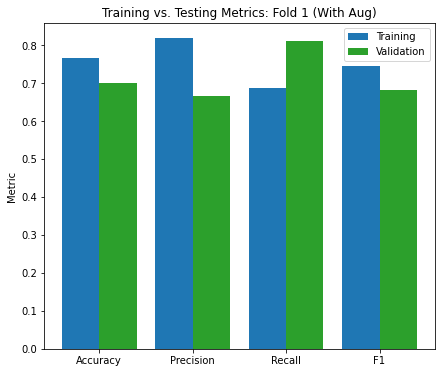

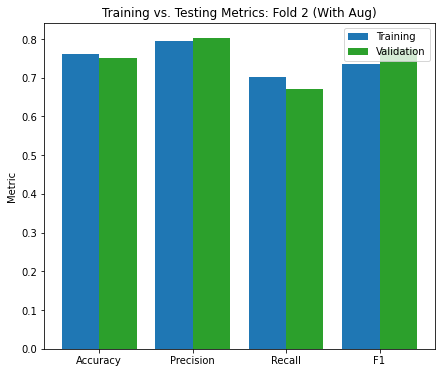

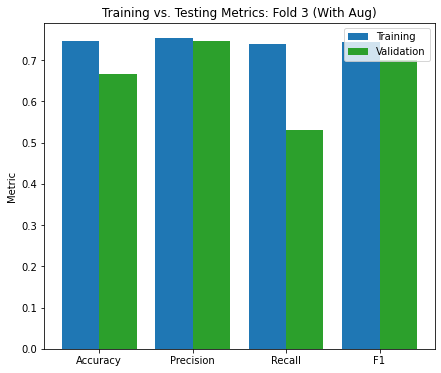

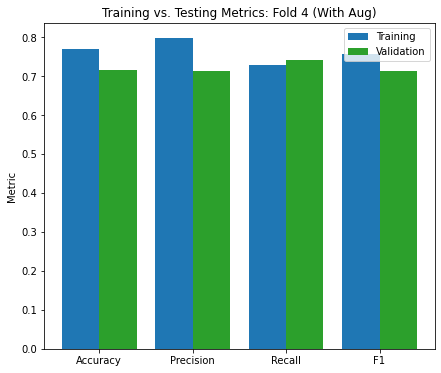

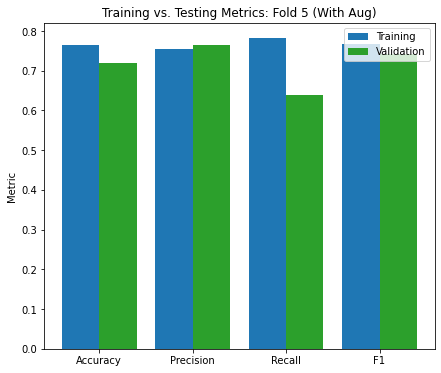

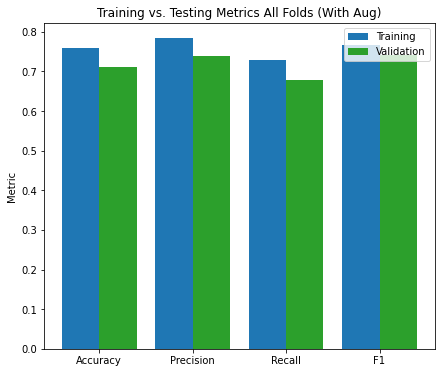

In [205]:
import matplotlib.pyplot as plt
import numpy as np

for FOLD_NUMBER in range(6): 
    
    if FOLD_NUMBER == 5: 
        training_acc = round(METRICS[:, 0].mean(), 3)
        training_precision = round(METRICS[:, 1].mean(), 3)
        training_recall = round(METRICS[:, 2].mean(), 3)
        validation_acc = round(METRICS[:, 3].mean(), 3)
        validation_precision = round(METRICS[:, 4].mean(), 3)
        validation_recall = round(METRICS[:, 5].mean(), 3)

        train_f1 = hmean(training_precision, train_recall)
        val_f1 = hmean(validation_precision, validation_recall)
    
    else : 
        metrics = METRICS_DICT[FOLD_NUMBER]
        training_acc = round(metrics[:, 0].mean(), 3)
        training_precision = round(metrics[:, 1].mean(), 3)
        training_recall = round(metrics[:, 2].mean(), 3)
        validation_acc = round(metrics[:, 3].mean(), 3)
        validation_precision = round(metrics[:, 4].mean(), 3)
        validation_recall = round(metrics[:, 5].mean(), 3)


        training_f1 = hmean(metrics[:, 1], metrics[:, 2]).mean()
        validation_f1 = hmean(metrics[:, 3], metrics[:, 4]).mean()

    labels = ['Accuracy', "Precision", "Recall", "F1"]

    x = np.arange(len(labels))  # the label locations
    width = 0.4  # the width of the bars

    fig, ax = plt.subplots()
    fig.set_size_inches(7, 6)
    rects1 = ax.bar(x - width/2, [training_acc, training_precision, training_recall, training_f1], width, label='Training', color = "tab:blue")
    rects2 = ax.bar(x + width/2, [validation_acc, validation_precision, validation_recall, validation_f1], width, label='Validation', color="tab:green")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Metric')
    if FOLD_NUMBER != 5: 
        ax.set_title(f"Training vs. Testing Metrics: Fold {FOLD_NUMBER + 1} (With Aug)")
    else: 
        ax.set_title("Training vs. Testing Metrics All Folds (With Aug)")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(loc="upper right")

    #ax.bar_label(rects1, padding=3)
    #ax.bar_label(rects2, padding=3)

    if FOLD_NUMBER != 5 : 
        plt.savefig(f"balanced_plots/train_vs_test_{FOLD_NUMBER + 1}_aug.png")

    else: 
        plt.savefig("balanced_plots/train_vs_test_all_aug.png")
    plt.show()